In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import requests
import os
import matplotlib.pyplot as plt

In [2]:
from dotenv import load_dotenv
import os
load_dotenv()  # reads the .env file automatically

True

In [3]:
import os, requests, pandas as pd

API_KEY = os.getenv("EIA_KEY")  # set first: export EIA_KEY="your_key"
BASE = "https://api.eia.gov/v2/electricity/rto/daily-fuel-type-data/data/"

COMMON = {
    "frequency": "daily",
    "data[0]": "value",
    "facets[respondent][]": "CAL",
    "facets[timezone][]": "Pacific",      # << your addition
    "start": "2019-01-01",
    "end":   "2025-09-27",
    "sort[0][column]": "period",
    "sort[0][direction]": "desc",         # keep your sort direction
    "length": 5000,
}

def fetch_all_daily():
    rows, offset, total = [], 0, None
    while True:
        params = COMMON.copy()
        params["api_key"] = API_KEY
        params["offset"]  = offset

        r = requests.get(BASE, params=params, timeout=60)
        r.raise_for_status()
        resp = r.json()["response"]

        if total is None:
            total = int(resp.get("total", 0))

        chunk = resp.get("data", [])
        rows.extend(chunk)
        print(f"Fetched {len(chunk):4d} rows @ offset {offset:,} "
              f"({len(rows):,}/{total:,})")

        if len(chunk) < params["length"] or offset + params["length"] >= total:
            break
        offset += params["length"]

    df = pd.DataFrame(rows)
    if df.empty:
        return df

    # Parse / clean
    # 'period' is daily like 'YYYY-MM-DD' (Pacific-local calendar day)
    df["period"] = pd.to_datetime(df["period"], format="%Y-%m-%d", errors="coerce")
    df["value"]  = pd.to_numeric(df["value"], errors="coerce")

    # Keep useful columns if present
    keep = ["period","respondent","respondent-name","fueltype","type-name",
            "timezone","value","value-units"]
    df = df[[c for c in keep if c in df.columns]].sort_values(["period","fueltype"])

    return df

if __name__ == "__main__":
    df_daily = fetch_all_daily()
    print("Daily shape:", df_daily.shape)
    if not df_daily.empty:
        df_daily.to_csv("eia_CAL_fueltype_daily_Pacific_2019_2025-09-27.csv", index=False)
        print(df_daily.head(10))

Fetched 5000 rows @ offset 0 (5,000/20,748)
Fetched 5000 rows @ offset 5,000 (10,000/20,748)
Fetched 5000 rows @ offset 10,000 (15,000/20,748)
Fetched 5000 rows @ offset 15,000 (20,000/20,748)
Fetched  748 rows @ offset 20,000 (20,748/20,748)
Daily shape: (20748, 8)
          period respondent respondent-name fueltype    type-name timezone  \
20740 2019-01-01        CAL      California      COL         Coal  Pacific   
20741 2019-01-01        CAL      California       NG  Natural Gas  Pacific   
20742 2019-01-01        CAL      California      NUC      Nuclear  Pacific   
20743 2019-01-01        CAL      California      OIL    Petroleum  Pacific   
20744 2019-01-01        CAL      California      OTH        Other  Pacific   
20745 2019-01-01        CAL      California      SUN        Solar  Pacific   
20746 2019-01-01        CAL      California      WAT        Hydro  Pacific   
20747 2019-01-01        CAL      California      WND         Wind  Pacific   
20732 2019-01-02        CAL    

In [4]:
df_daily.head()

period respondent respondent-name fueltype    type-name timezone  \
20740 2019-01-01        CAL      California      COL         Coal  Pacific   
20741 2019-01-01        CAL      California       NG  Natural Gas  Pacific   
20742 2019-01-01        CAL      California      NUC      Nuclear  Pacific   
20743 2019-01-01        CAL      California      OIL    Petroleum  Pacific   
20744 2019-01-01        CAL      California      OTH        Other  Pacific   

        value    value-units  
20740   36021  megawatthours  
20741  199638  megawatthours  
20742   54565  megawatthours  
20743    2150  megawatthours  
20744   17823  megawatthours

In [5]:
df_daily.shape

(20748, 8)

In [6]:
def get_la_weather_data():
    url = "https://archive-api.open-meteo.com/v1/archive"
    
    params = {
        "latitude": 34.0522,
        "longitude": -118.2437,
        "start_date": "2019-01-01",
        "end_date": "2025-09-27",
        "daily": ["temperature_2m_mean", "precipitation_sum", "windspeed_10m_mean", 
                 "relative_humidity_2m_mean", "pressure_msl_mean"],
        "timezone": "America/Los_Angeles"
    }
    
    response = requests.get(url, params=params)
    data = response.json()
    
    # Convert to DataFrame
    df = pd.DataFrame({
        'date': pd.to_datetime(data['daily']['time']),
        'temperature_avg_c': data['daily']['temperature_2m_mean'],
        'precipitation_mm': data['daily']['precipitation_sum'],
        'wind_speed_kmh': data['daily']['windspeed_10m_mean'],
        'humidity_percent': data['daily']['relative_humidity_2m_mean'],
        'pressure_hpa': data['daily']['pressure_msl_mean']
    })
    
    return df

# Get the data
weather_data = get_la_weather_data()
print(weather_data.head())

        date  temperature_avg_c  precipitation_mm  wind_speed_kmh  \
0 2019-01-01                8.4               0.0             9.5   
1 2019-01-02                8.9               0.0             5.3   
2 2019-01-03               11.4               0.0             5.6   
3 2019-01-04               12.3               0.0             6.4   
4 2019-01-05               11.1               8.2             9.5   

   humidity_percent  pressure_hpa  
0                22        1019.4  
1                21        1022.4  
2                30        1021.5  
3                38        1016.5  
4                78        1014.8  


In [7]:
weather_data.head()

date  temperature_avg_c  precipitation_mm  wind_speed_kmh  \
0 2019-01-01                8.4               0.0             9.5   
1 2019-01-02                8.9               0.0             5.3   
2 2019-01-03               11.4               0.0             5.6   
3 2019-01-04               12.3               0.0             6.4   
4 2019-01-05               11.1               8.2             9.5   

   humidity_percent  pressure_hpa  
0                22        1019.4  
1                21        1022.4  
2                30        1021.5  
3                38        1016.5  
4                78        1014.8

In [8]:
df_daily.dtypes

period             datetime64[ns]
respondent                 object
respondent-name            object
fueltype                   object
type-name                  object
timezone                   object
value                       int64
value-units                object
dtype: object

In [9]:
weather_data.dtypes

date                 datetime64[ns]
temperature_avg_c           float64
precipitation_mm            float64
wind_speed_kmh              float64
humidity_percent              int64
pressure_hpa                float64
dtype: object

In [10]:
df_daily.head()

period respondent respondent-name fueltype    type-name timezone  \
20740 2019-01-01        CAL      California      COL         Coal  Pacific   
20741 2019-01-01        CAL      California       NG  Natural Gas  Pacific   
20742 2019-01-01        CAL      California      NUC      Nuclear  Pacific   
20743 2019-01-01        CAL      California      OIL    Petroleum  Pacific   
20744 2019-01-01        CAL      California      OTH        Other  Pacific   

        value    value-units  
20740   36021  megawatthours  
20741  199638  megawatthours  
20742   54565  megawatthours  
20743    2150  megawatthours  
20744   17823  megawatthours

In [11]:
# Sum values across all fuel types per day
daily_total = (
    df_daily.groupby("period", as_index=False)["value"]
            .sum()
            .rename(columns={"value": "total_value"})
)

# Now daily_total has only 'period' and 'total_value' columns
print(daily_total.head())

      period  total_value
0 2019-01-01       465701
1 2019-01-02       488901
2 2019-01-03       484062
3 2019-01-04       477305
4 2019-01-05       451001


In [12]:
daily_total.head()

period  total_value
0 2019-01-01       465701
1 2019-01-02       488901
2 2019-01-03       484062
3 2019-01-04       477305
4 2019-01-05       451001

In [13]:
daily_total.shape

(2462, 2)

In [14]:
df_merged = pd.merge(daily_total, weather_data, left_on='period', right_on='date', how='inner')

In [15]:
df_merged.shape

(2462, 8)

In [16]:
df_merged.head()

period  total_value       date  temperature_avg_c  precipitation_mm  \
0 2019-01-01       465701 2019-01-01                8.4               0.0   
1 2019-01-02       488901 2019-01-02                8.9               0.0   
2 2019-01-03       484062 2019-01-03               11.4               0.0   
3 2019-01-04       477305 2019-01-04               12.3               0.0   
4 2019-01-05       451001 2019-01-05               11.1               8.2   

   wind_speed_kmh  humidity_percent  pressure_hpa  
0             9.5                22        1019.4  
1             5.3                21        1022.4  
2             5.6                30        1021.5  
3             6.4                38        1016.5  
4             9.5                78        1014.8

In [17]:
df_merged.describe()

period    total_value                 date  \
count                 2462    2462.000000                 2462   
mean   2022-05-15 12:00:00  575890.470755  2022-05-15 12:00:00   
min    2019-01-01 00:00:00   91499.000000  2019-01-01 00:00:00   
25%    2020-09-07 06:00:00  488972.250000  2020-09-07 06:00:00   
50%    2022-05-15 12:00:00  560277.000000  2022-05-15 12:00:00   
75%    2024-01-20 18:00:00  642445.500000  2024-01-20 18:00:00   
max    2025-09-27 00:00:00  986686.000000  2025-09-27 00:00:00   
std                    NaN  119562.450205                  NaN   

       temperature_avg_c  precipitation_mm  wind_speed_kmh  humidity_percent  \
count        2462.000000       2462.000000     2462.000000       2462.000000   
mean           17.546466          1.295085        7.914135         63.468318   
min             6.300000          0.000000        1.500000          9.000000   
25%            13.600000          0.000000        6.300000         56.000000   
50%            17.500000          0.000000        7.800000         68.000000   
75%            21.300000          0.000000        9.000000         74.000000   
max            34.300000         84.700000       27.800000         96.000000   
std             4.781541          6.136019        2.549354         16.712584   

       pressure_hpa  
count   2462.000000  
mean    1015.019212  
min     1001.100000  
25%     1012.500000  
50%     1014.500000  
75%     1017.500000  
max     1028.400000  
std        3.713367

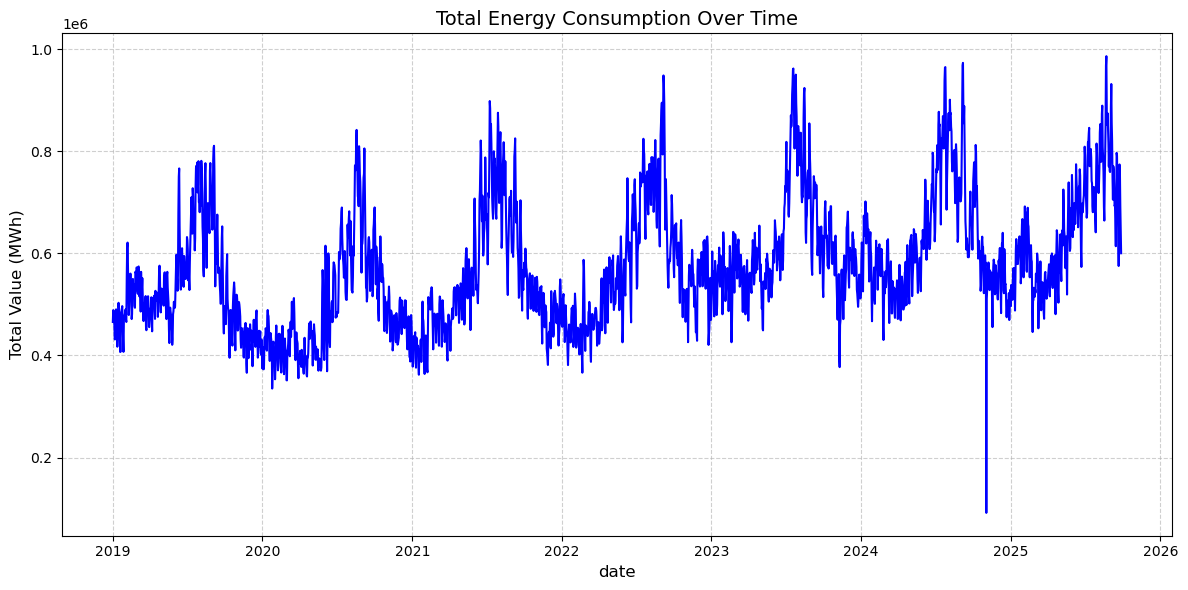

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
sns.lineplot(data=df_merged, x="date", y="total_value", color="blue")

plt.title("Total Energy Consumption Over Time", fontsize=14)
plt.xlabel("date", fontsize=12)
plt.ylabel("Total Value (MWh)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

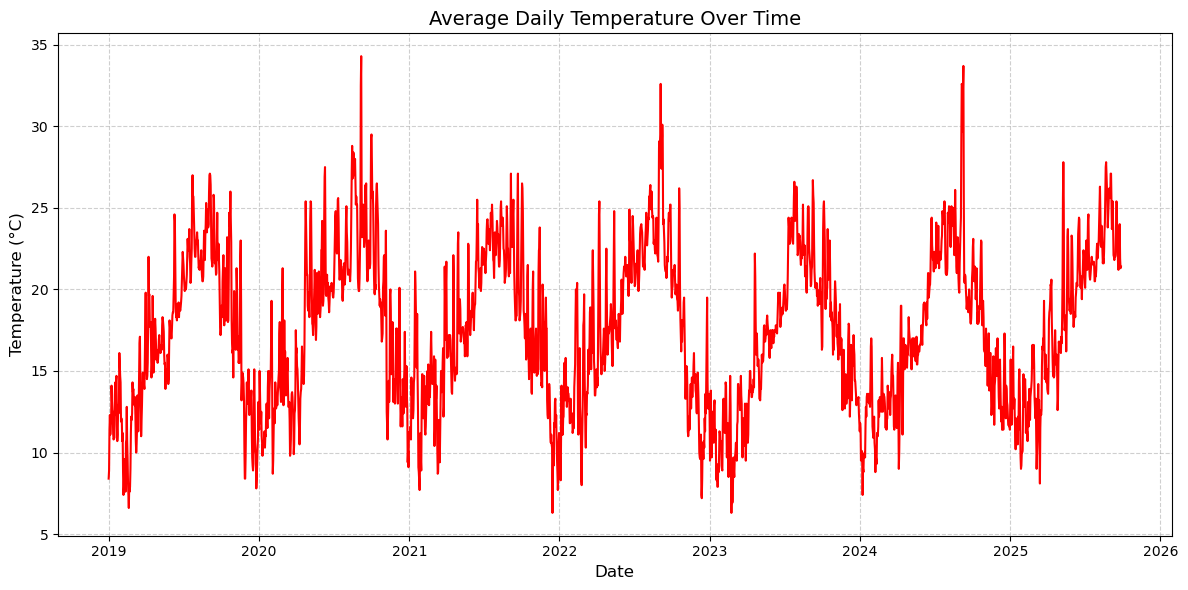

In [19]:
plt.figure(figsize=(12,6))
sns.lineplot(data=df_merged, x="date", y="temperature_avg_c", color="red")

plt.title("Average Daily Temperature Over Time", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Temperature (°C)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

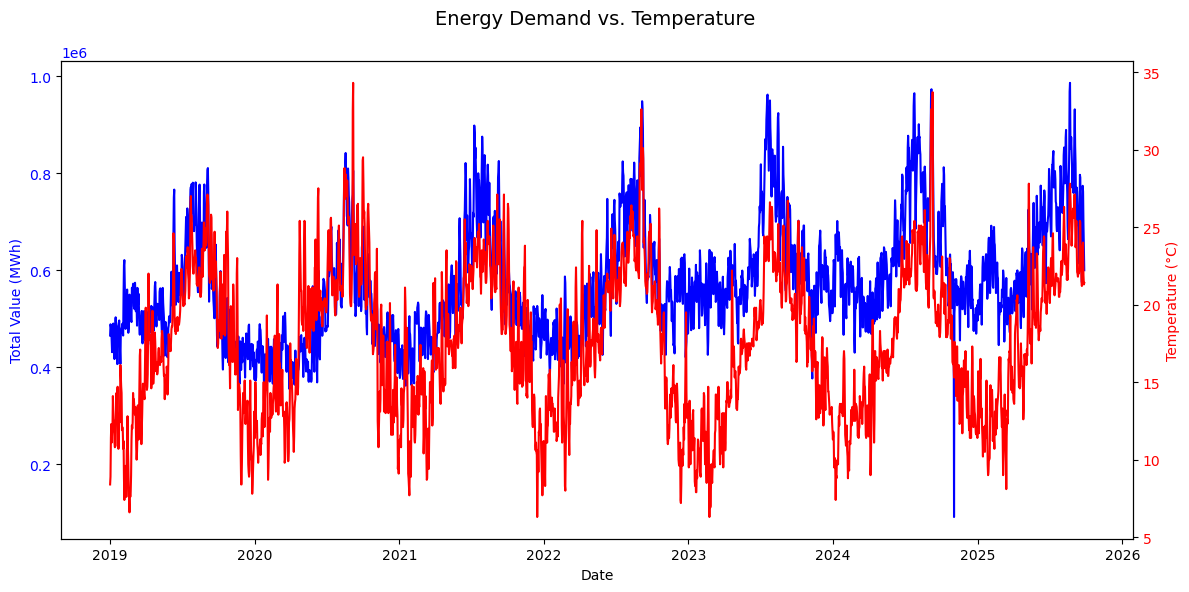

In [20]:
fig, ax1 = plt.subplots(figsize=(12,6))

# Plot total energy
ax1.set_xlabel("Date")
ax1.set_ylabel("Total Value (MWh)", color="blue")
ax1.plot(df_merged["date"], df_merged["total_value"], color="blue", label="Total Value")
ax1.tick_params(axis="y", labelcolor="blue")

# Twin axis for temperature
ax2 = ax1.twinx()
ax2.set_ylabel("Temperature (°C)", color="red")
ax2.plot(df_merged["date"], df_merged["temperature_avg_c"], color="red", label="Temperature")
ax2.tick_params(axis="y", labelcolor="red")

fig.suptitle("Energy Demand vs. Temperature", fontsize=14)
fig.tight_layout()
plt.show()

/var/folders/yg/f1g020cd6zl_n34fsq8_h_2r0000gn/T/ipykernel_11481/3981550314.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample("M")


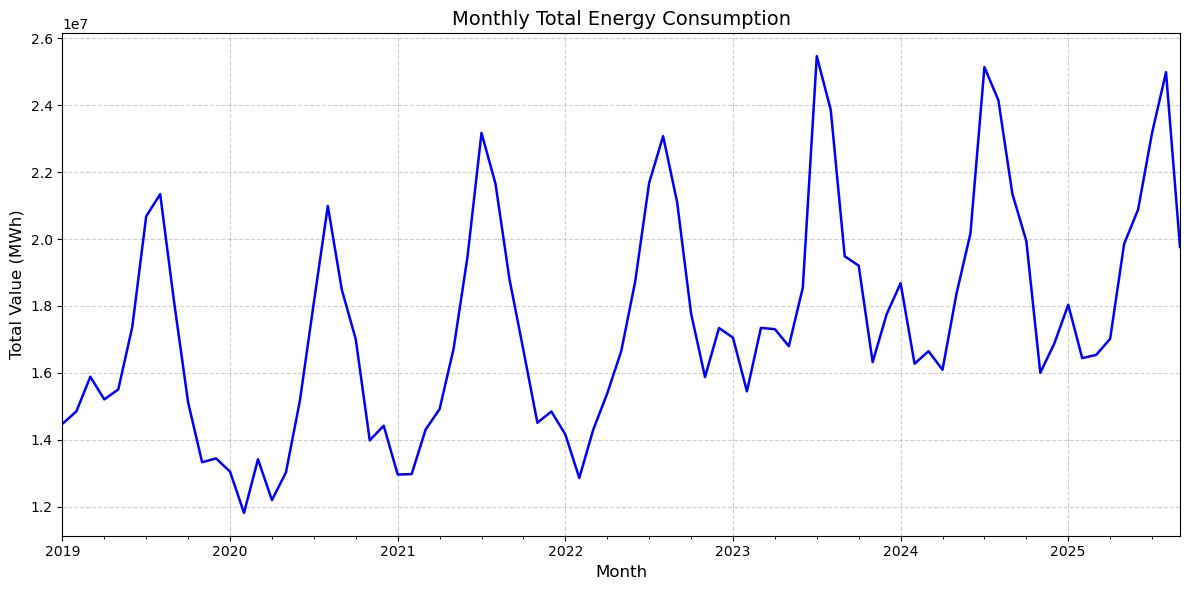

In [21]:
# Resample by month and sum values
monthly_total = (
    df_merged.set_index("date")["total_value"]
             .resample("M")
             .sum()
)

# Plot
plt.figure(figsize=(12,6))
monthly_total.plot(kind="line", color="blue", linewidth=1.8)

plt.title("Monthly Total Energy Consumption", fontsize=14)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Total Value (MWh)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

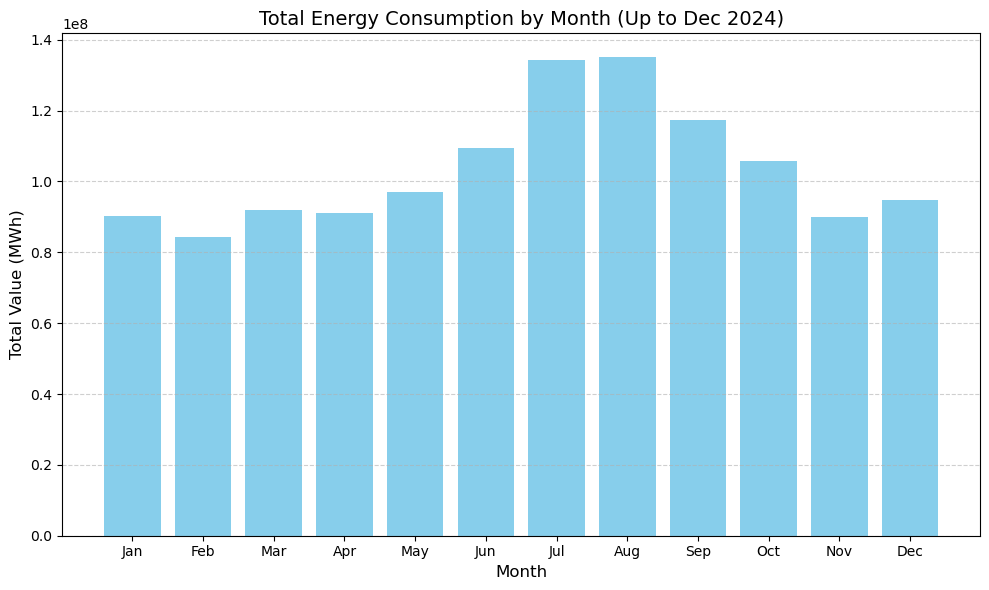

In [22]:
# Filter up to Dec 31, 2024
df_filtered = df_merged[df_merged["date"] <= "2024-12-31"]

# Group by month across all years
monthly_totals = (
    df_filtered.groupby(df_filtered["date"].dt.month)["total_value"]
               .sum()
)

# Month labels
month_labels = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]

# Plot
plt.figure(figsize=(10,6))
plt.bar(month_labels, monthly_totals, color="skyblue")

plt.title("Total Energy Consumption by Month (Up to Dec 2024)", fontsize=14)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Total Value (MWh)", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

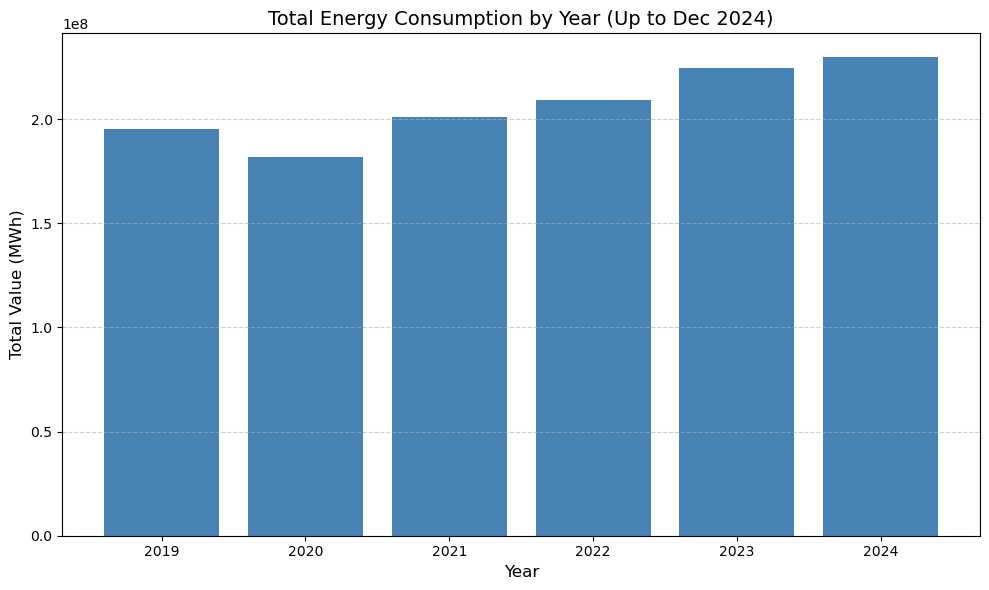

In [23]:
# Group by year
yearly_totals = (
    df_filtered.groupby(df_filtered["date"].dt.year)["total_value"]
               .sum()
)

# Plot
plt.figure(figsize=(10,6))
plt.bar(yearly_totals.index.astype(str), yearly_totals.values, color="steelblue")

plt.title("Total Energy Consumption by Year (Up to Dec 2024)", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Total Value (MWh)", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

In [24]:
df_merged.set_index("date", inplace=True)
df_merged.head()

period  total_value  temperature_avg_c  precipitation_mm  \
date                                                                      
2019-01-01 2019-01-01       465701                8.4               0.0   
2019-01-02 2019-01-02       488901                8.9               0.0   
2019-01-03 2019-01-03       484062               11.4               0.0   
2019-01-04 2019-01-04       477305               12.3               0.0   
2019-01-05 2019-01-05       451001               11.1               8.2   

            wind_speed_kmh  humidity_percent  pressure_hpa  
date                                                        
2019-01-01             9.5                22        1019.4  
2019-01-02             5.3                21        1022.4  
2019-01-03             5.6                30        1021.5  
2019-01-04             6.4                38        1016.5  
2019-01-05             9.5                78        1014.8

In [25]:
df_merged.drop(columns=["period"], inplace=True)

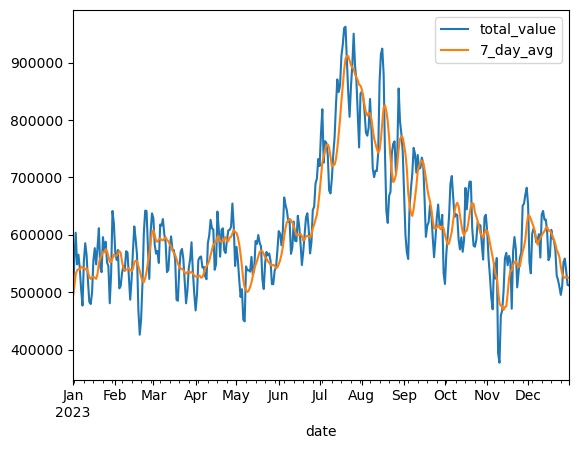

In [26]:
df_merged['7_day_avg'] = df_merged['total_value'].rolling(window=7).mean()
df_merged[['total_value', '7_day_avg']].loc['2023'].plot()
plt.show()

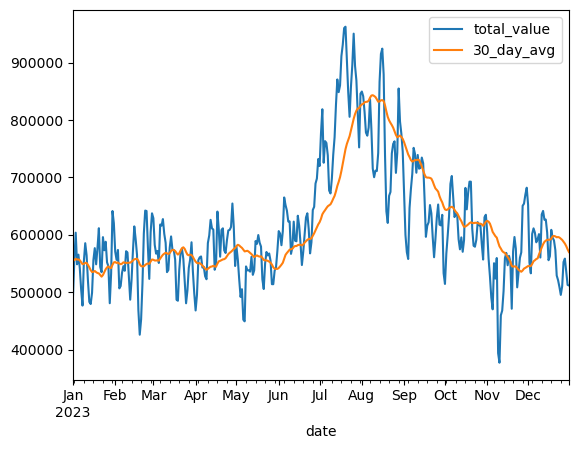

In [27]:
df_merged['30_day_avg'] = df_merged['total_value'].rolling(window=30).mean()
df_merged[['total_value', '30_day_avg']].loc['2023'].plot()
plt.show()

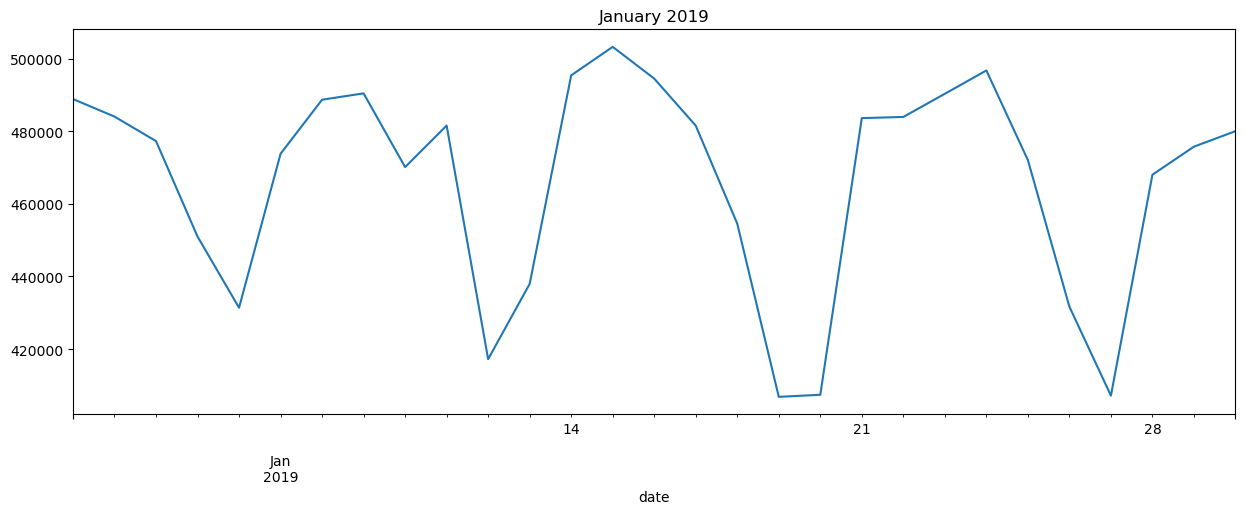

In [28]:
df_merged['total_value'].loc[(df_merged.index > '2019-01-01') & (df_merged.index <'2019-01-31')].plot(figsize=(15,5), title='January 2019')
plt.show()

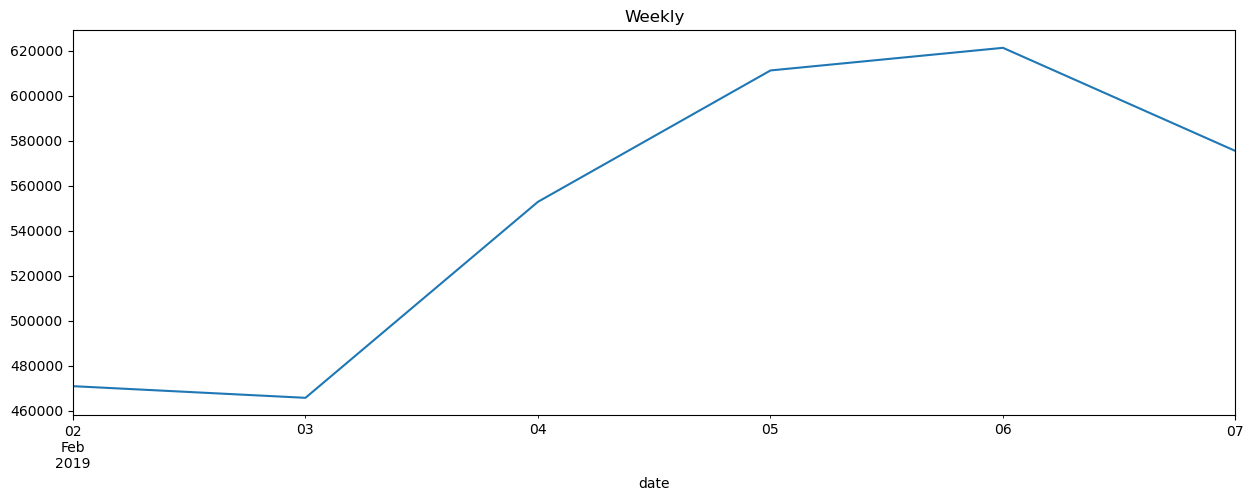

In [29]:
df_merged['total_value'].loc[(df_merged.index > '2019-02-01') & (df_merged.index <'2019-02-08')].plot(figsize=(15,5), title='Weekly')
plt.show()

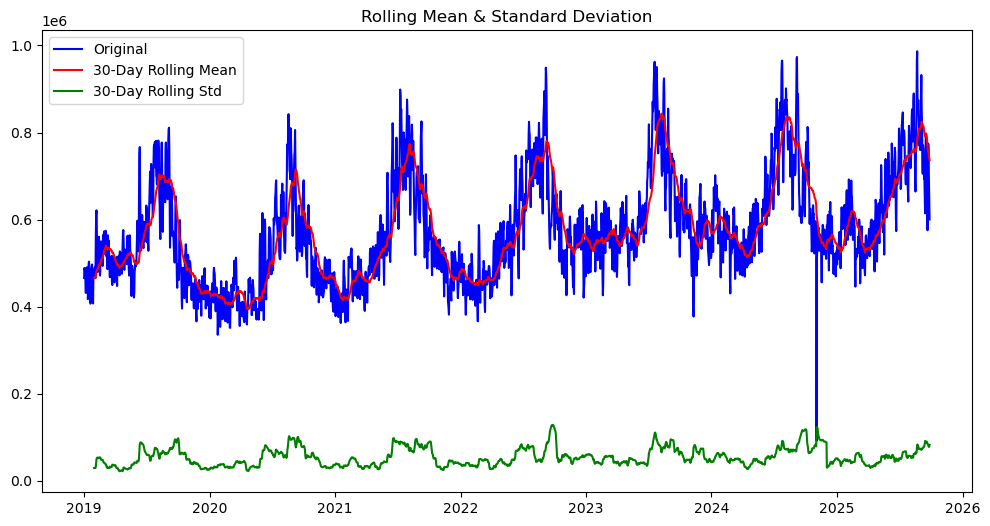

In [30]:
# Check for statonarity
# Plot 30 day folling mean and std
rolling_mean = df_merged['total_value'].rolling(window=30).mean()
rolling_std = df_merged['total_value'].rolling(window=30).std()
plt.figure(figsize=(12,6))
plt.plot(df_merged['total_value'], label='Original', color='blue')
plt.plot(rolling_mean, label='30-Day Rolling Mean', color='red')
plt.plot(rolling_std, label='30-Day Rolling Std', color='green')
plt.legend()
plt.title('Rolling Mean & Standard Deviation')
plt.show()


In [31]:
df_merged.shape

(2462, 8)

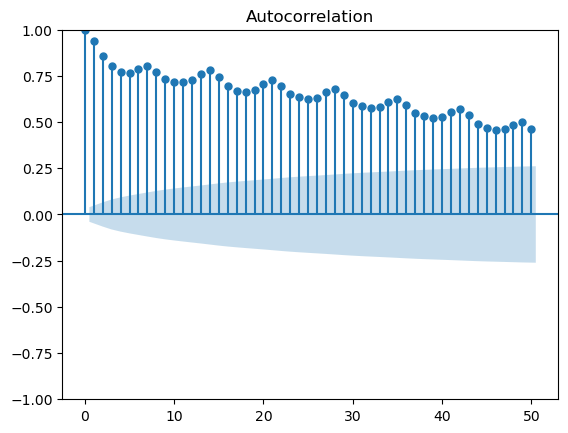

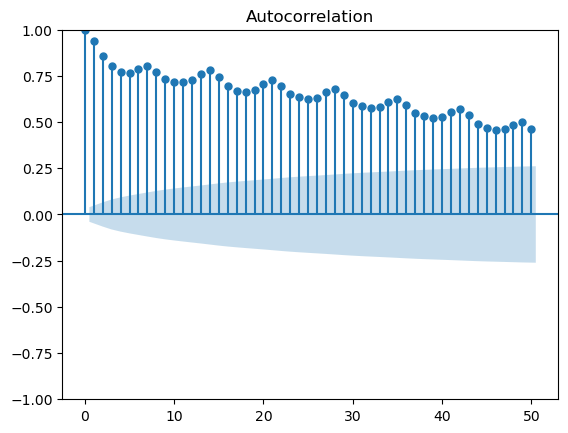

In [32]:
from statsmodels.graphics.tsaplots import plot_acf

# Plot up to 40 lags
plot_acf(df_merged["total_value"], lags=50)

In [33]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df_merged["total_value"])
print("ADF Statistic:", result[0])
print("p-value:", result[1])
for key, value in result[4].items():
    print(f"Critical Value {key}: {value}")

ADF Statistic: -2.9496166979847427
p-value: 0.03987502771034722
Critical Value 1%: -3.4330383807110296
Critical Value 5%: -2.8627276983827623
Critical Value 10%: -2.5674022602026403


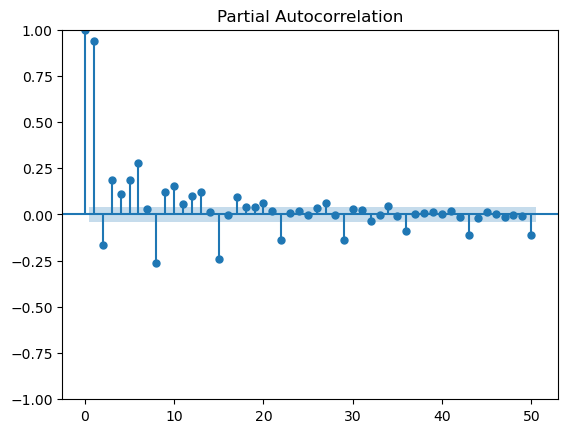

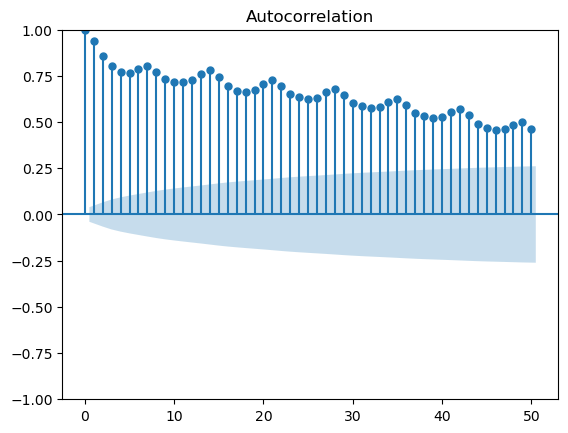

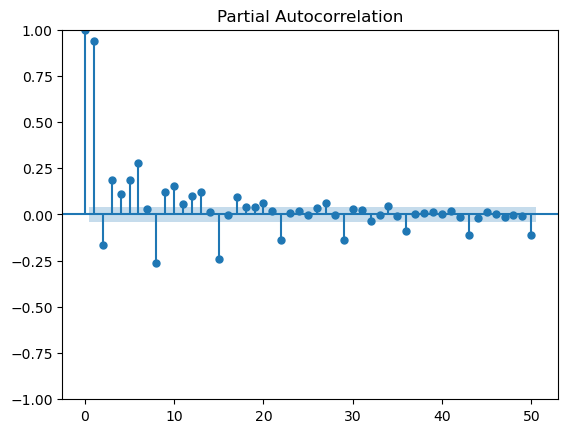

In [34]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(df_merged["total_value"], lags=50)
plot_pacf(df_merged["total_value"], lags=50)

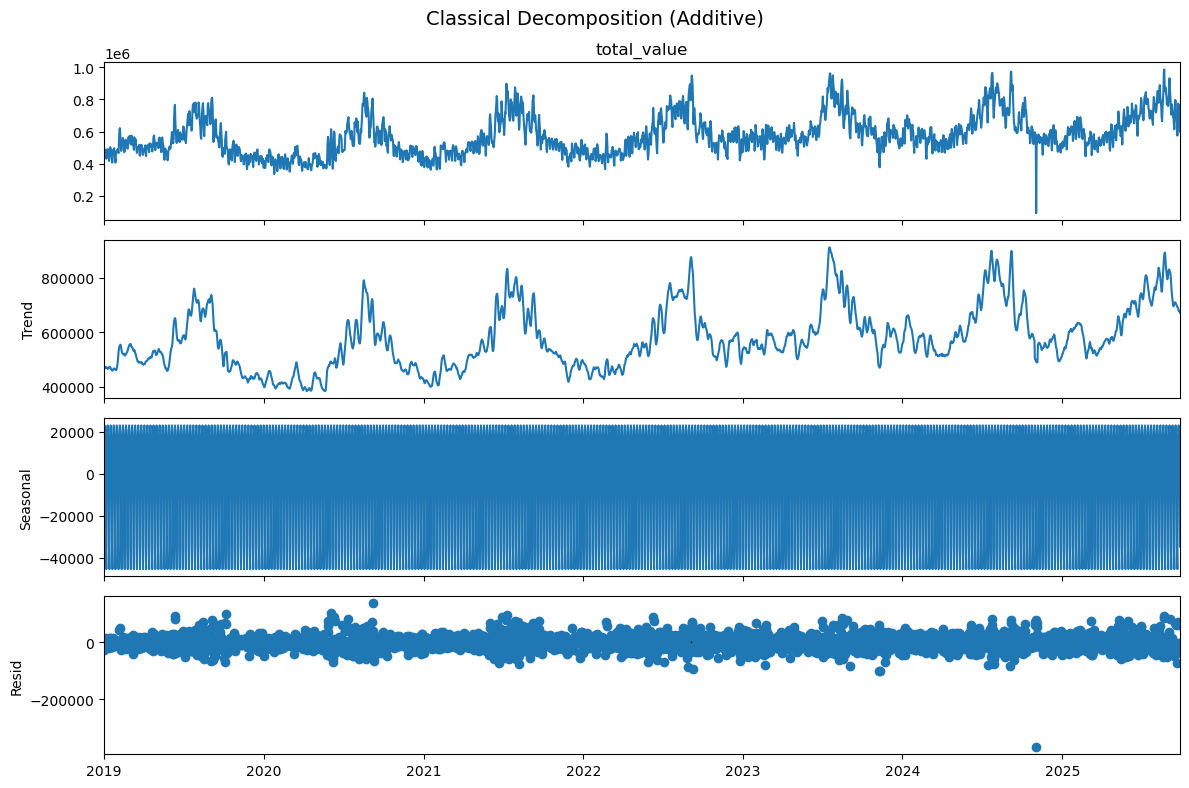

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# ---- Prep your series ----
# df must have a datetime column and a numeric target (e.g., 'date', 'total_value')
df = df_merged.copy()
#df["date"] = pd.to_datetime(df["date"])
#df = df.set_index("date").sort_index()

# If daily data with weekly seasonality, period=7
# If hourly data with daily seasonality, period=24 (or 168 for weekly)
period = 7  # change to 24/168/12/etc. based on your frequency

# Option: handle small gaps
y = df["total_value"].asfreq("D")  # "D" for daily; use "H" for hourly
y = y.interpolate(limit_direction="both")

# ---- Decompose ----
result = seasonal_decompose(y, model="additive", period=period, extrapolate_trend="freq")

# ---- Plot ----
fig = result.plot()
fig.set_size_inches(12, 8)
fig.suptitle("Classical Decomposition (Additive)", fontsize=14, y=0.98)
plt.tight_layout()
plt.show()

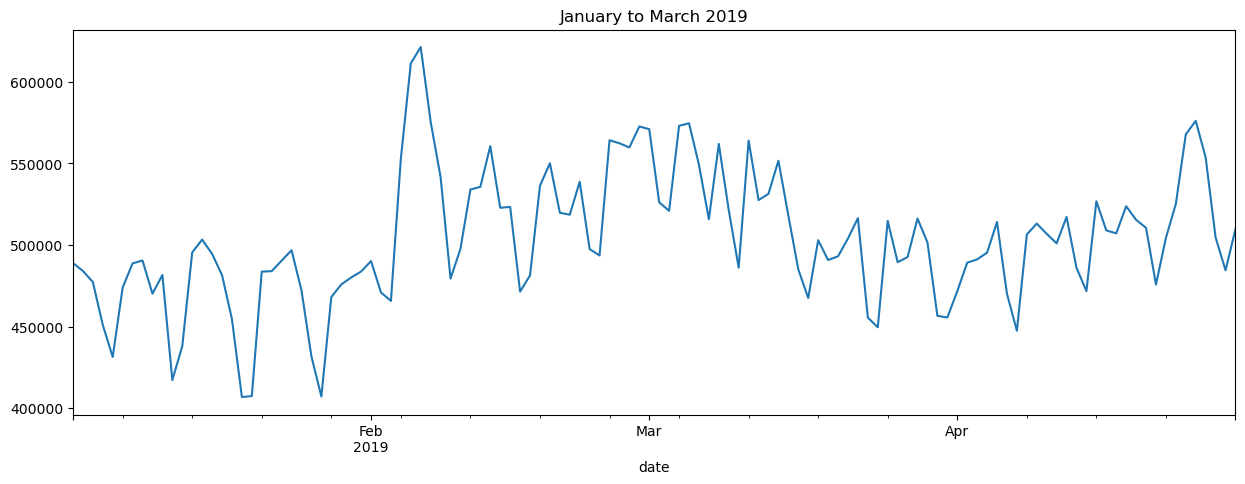

In [36]:
df_merged['total_value'].loc[(df_merged.index > '2019-01-01') & (df_merged.index <'2019-04-30')].plot(figsize=(15,5), title='January to March 2019')
plt.show()

In [37]:
list(df_merged.loc['2019-01-01':'2019-02-18']['total_value'])

[465701,
 488901,
 484062,
 477305,
 451001,
 431380,
 473814,
 488715,
 490462,
 470146,
 481587,
 417211,
 437955,
 495428,
 503286,
 494536,
 481566,
 454553,
 406819,
 407390,
 483640,
 483964,
 490352,
 496774,
 472077,
 431673,
 407148,
 468045,
 475778,
 480045,
 483722,
 490096,
 470893,
 465715,
 552830,
 611213,
 621268,
 575418,
 541542,
 479383,
 497657,
 533983,
 535561,
 560545,
 522778,
 523296,
 471411,
 481327,
 536245]

In [38]:
diff_7 = df_merged['total_value'].diff(periods=7)["2019-01-01":"2025-09-27"]

<Axes: title={'center': '7-day differencing Jan 2019 to Sept 2025'}, xlabel='date'>

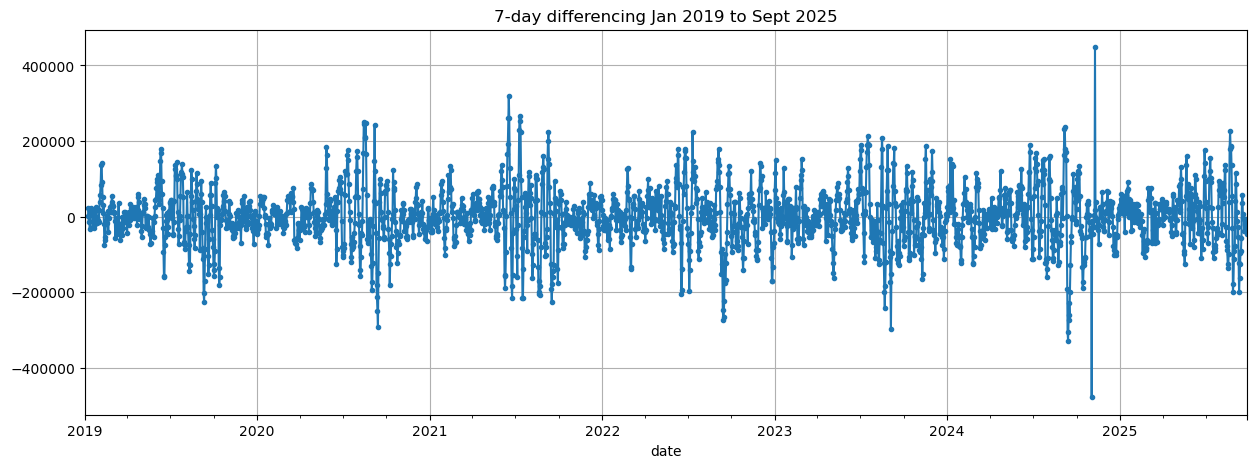

In [39]:
diff_7.plot(figsize=(15,5), grid=True, marker=".", title='7-day differencing Jan 2019 to Sept 2025')   

/var/folders/yg/f1g020cd6zl_n34fsq8_h_2r0000gn/T/ipykernel_11481/2522324074.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = df_merged['total_value'].resample('M').mean()


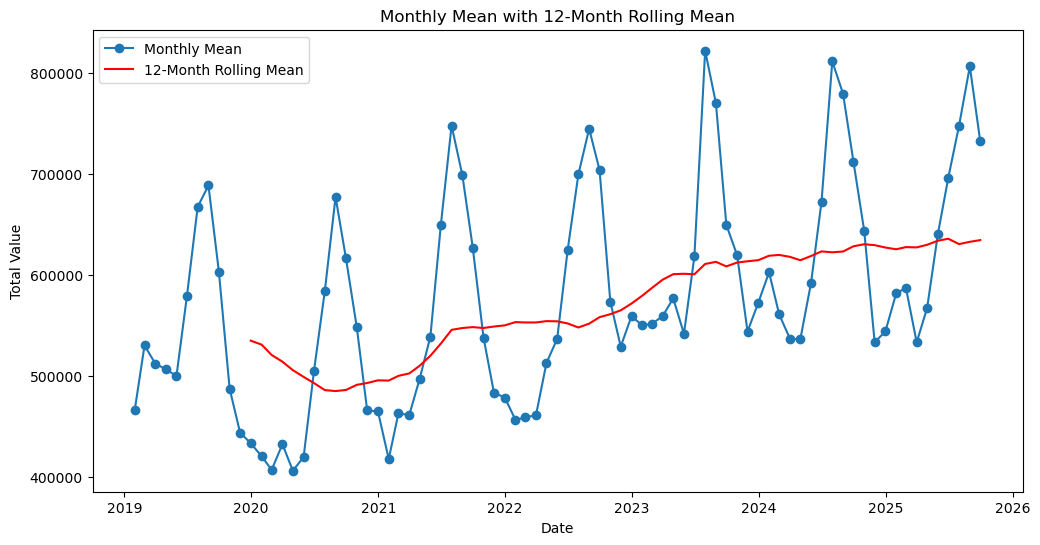

In [40]:
df_monthly = df_merged['total_value'].resample('M').mean()
rolling_mean_12 = df_monthly.rolling(window=12).mean()

fig, ax = plt.subplots(figsize=(12,6))
ax.plot(df_monthly, label='Monthly Mean', marker='o')
ax.plot(rolling_mean_12, label='12-Month Rolling Mean', color='red')
ax.set_title('Monthly Mean with 12-Month Rolling Mean')
ax.set_xlabel('Date')
ax.set_ylabel('Total Value')
ax.legend()
plt.show()


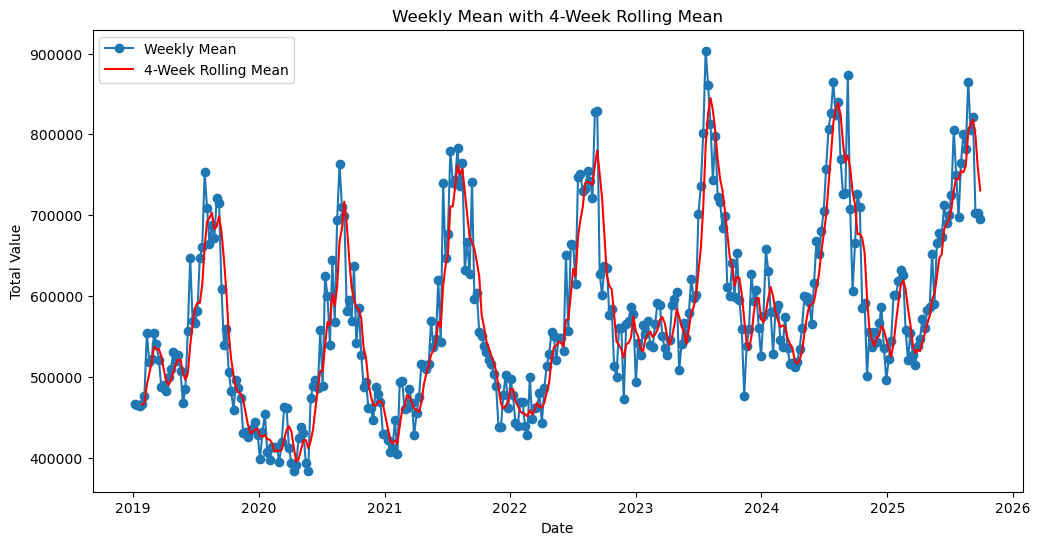

In [41]:
df_weekly = df_merged['total_value'].resample('W').mean()
rolling_mean_4 = df_weekly.rolling(window=4).mean()

fig, ax = plt.subplots(figsize=(12,6))
ax.plot(df_weekly, label='Weekly Mean', marker='o')
ax.plot(rolling_mean_4, label='4-Week Rolling Mean', color='red')
ax.set_title('Weekly Mean with 4-Week Rolling Mean')
ax.set_xlabel('Date')
ax.set_ylabel('Total Value')
ax.legend()
plt.show()


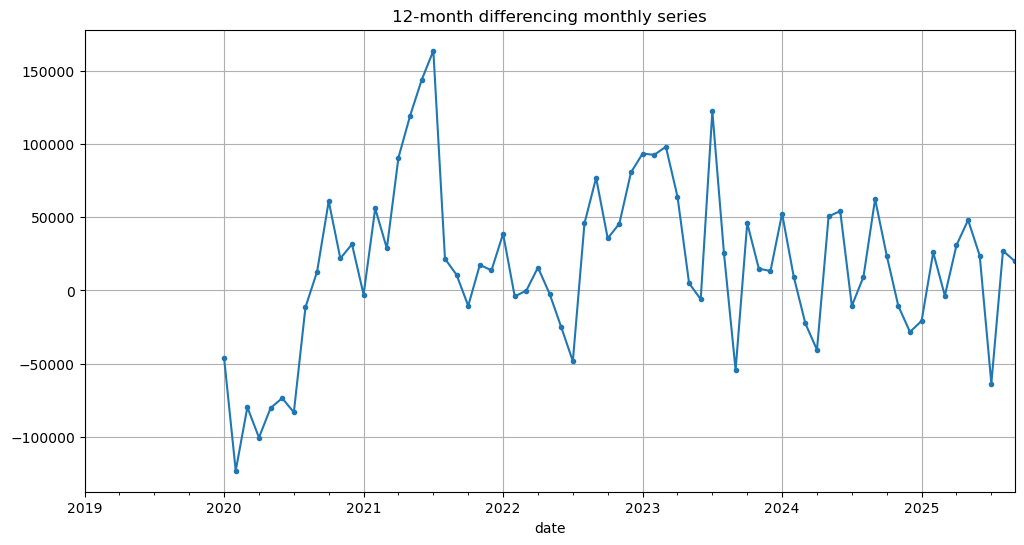

In [42]:
df_monthly.diff(12).plot(grid=True, marker=".", figsize=(12,6), title='12-month differencing monthly series')
plt.show()

Best by AIC: (2, 0, 2) (1, 1, 1, 7) AIC: 45955.84
Validation  MAE: 105,921.986   RMSE: 139,913.144


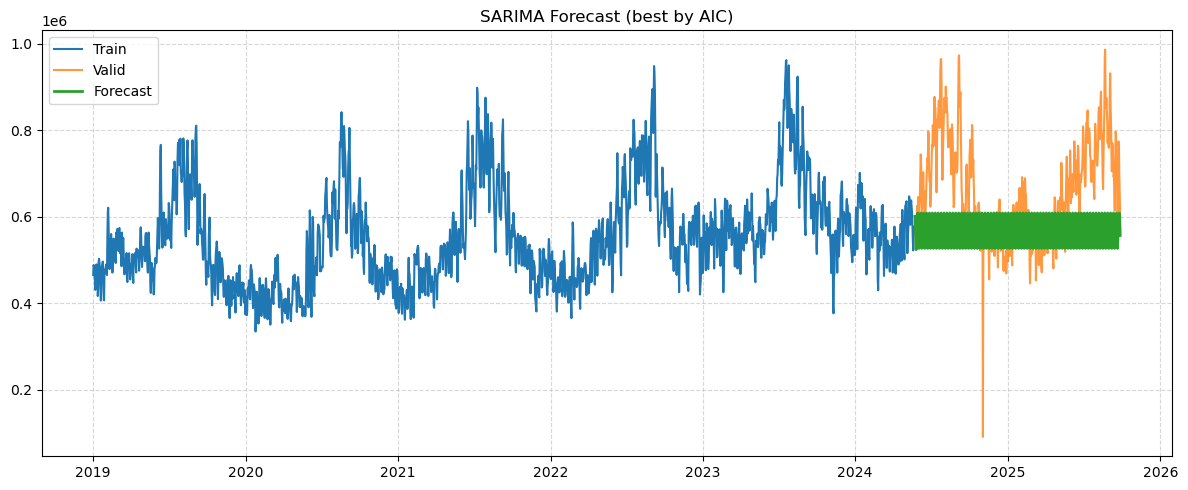

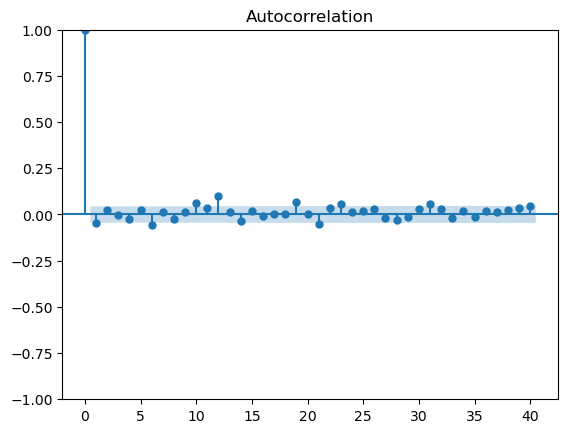

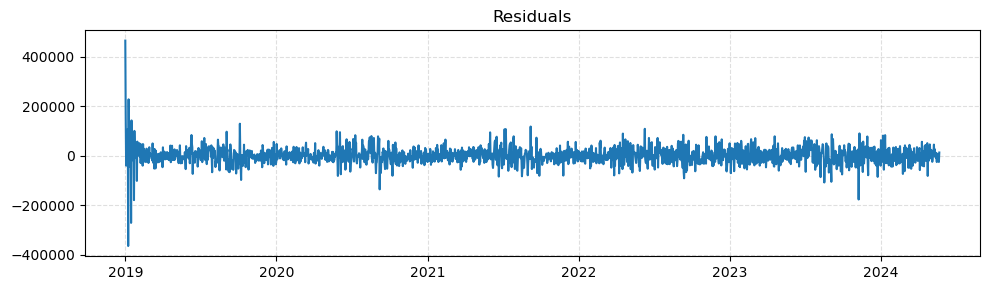

In [43]:
import pandas as pd, numpy as np, itertools, warnings
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

# --- 0) Build target series from your prepared date column ---
# If your date is already the index, comment out the next line.
y = df_merged["total_value"].asfreq("D").interpolate(limit_direction="both")

# --- 1) Train/valid split (time-based) ---
valid_frac = 0.2
n = len(y); k = int(np.floor((1 - valid_frac) * n))
y_tr, y_va = y.iloc[:k], y.iloc[k:]

# --- 2) SARIMA grid search (parsimonious) ---
def sarima_grid(y_train, m=7, pqr=range(0,3), PQR=range(0,2)):
    best = {"aic": np.inf, "order": None, "sorder": None, "res": None}
    for p,d,q in itertools.product(pqr, repeat=3):
        for P,D,Q in itertools.product(PQR, repeat=3):
            try:
                mod = sm.tsa.statespace.SARIMAX(
                    y_train,
                    order=(p,d,q),
                    seasonal_order=(P,D,Q,m),
                    enforce_stationarity=False,
                    enforce_invertibility=False
                )
                res = mod.fit(disp=False)
                if res.aic < best["aic"]:
                    best = {"aic": res.aic, "order": (p,d,q), "sorder": (P,D,Q,m), "res": res}
            except:
                pass
    return best

m = 7  # weekly seasonality for daily data
best = sarima_grid(y_tr, m=m, pqr=range(0,3), PQR=range(0,2))
print("Best by AIC:", best["order"], best["sorder"], "AIC:", round(best["aic"],2))

# --- 3) Forecast & evaluate ---
n_va = len(y_va)
y_hat = best["res"].get_forecast(steps=n_va).predicted_mean
mae = mean_absolute_error(y_va, y_hat)
rmse = sqrt(mean_squared_error(y_va, y_hat))
print(f"Validation  MAE: {mae:,.3f}   RMSE: {rmse:,.3f}")

plt.figure(figsize=(12,5))
plt.plot(y_tr.index, y_tr, label="Train")
plt.plot(y_va.index, y_va, label="Valid", alpha=0.8)
plt.plot(y_hat.index, y_hat, label="Forecast", linewidth=2)
plt.title("SARIMA Forecast (best by AIC)")
plt.legend(); plt.grid(True, linestyle="--", alpha=0.5); plt.tight_layout(); plt.show()

# --- 4) Quick residual checks (should look like white noise) ---
resid = best["res"].resid.dropna()
fig = sm.graphics.tsa.plot_acf(resid, lags=40); plt.show()
plt.figure(figsize=(10,3)); plt.plot(resid); plt.title("Residuals"); plt.grid(True, linestyle="--", alpha=0.4); plt.tight_layout(); plt.show()

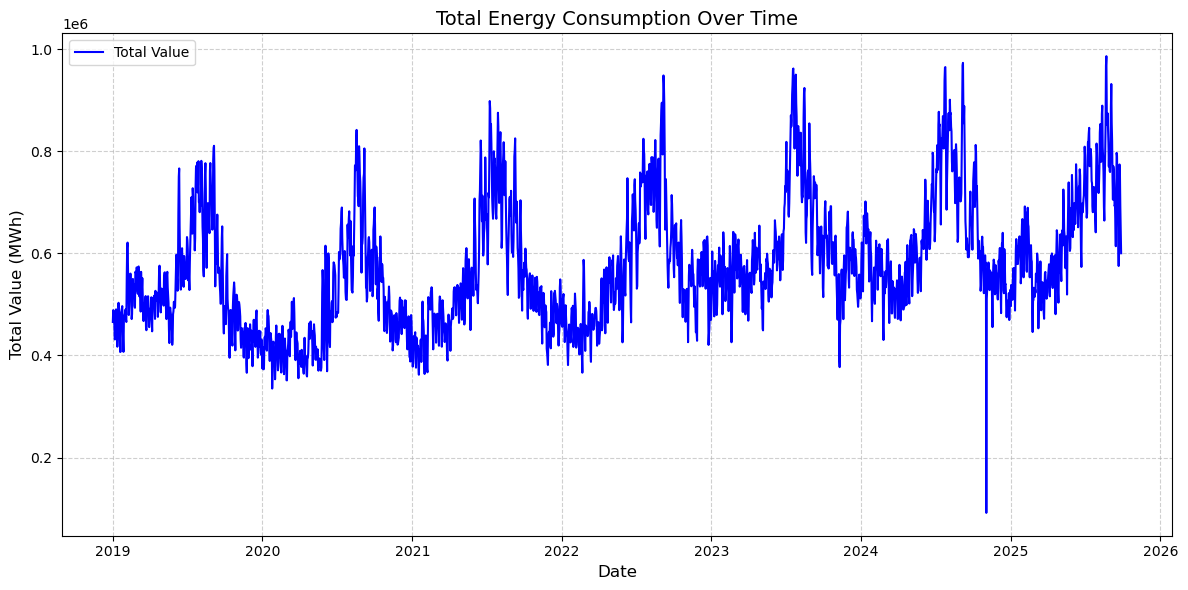

In [44]:
# Plot demand vs time
plt.figure(figsize=(12,6))
plt.plot(df_merged.index, df_merged['total_value'], label='Total Value', color='blue')
plt.title('Total Energy Consumption Over Time', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Value (MWh)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


In [45]:
#Identify the outliers
def rolling_outliers(series, window=30, sigma_threshold=3):
    """
    Detect outliers based on rolling mean and standard deviation
    """
    rolling_mean = series.rolling(window=window, center=True).mean()
    rolling_std = series.rolling(window=window, center=True).std()
    
    # Calculate z-scores relative to rolling statistics
    rolling_z = (series - rolling_mean) / rolling_std
    
    outliers = np.where(np.abs(rolling_z) > sigma_threshold)[0]
    outlier_dates = series.index[outliers]
    return outliers, rolling_z, outlier_dates

outliers, rolling_z, outlier_dates = rolling_outliers(df_merged['total_value'], window=30, sigma_threshold=3)

In [46]:
outliers, outlier_dates

(array([2132]),
 DatetimeIndex(['2024-11-02'], dtype='datetime64[ns]', name='date', freq=None))

<Axes: title={'center': '2024 with Outlier'}, xlabel='date'>

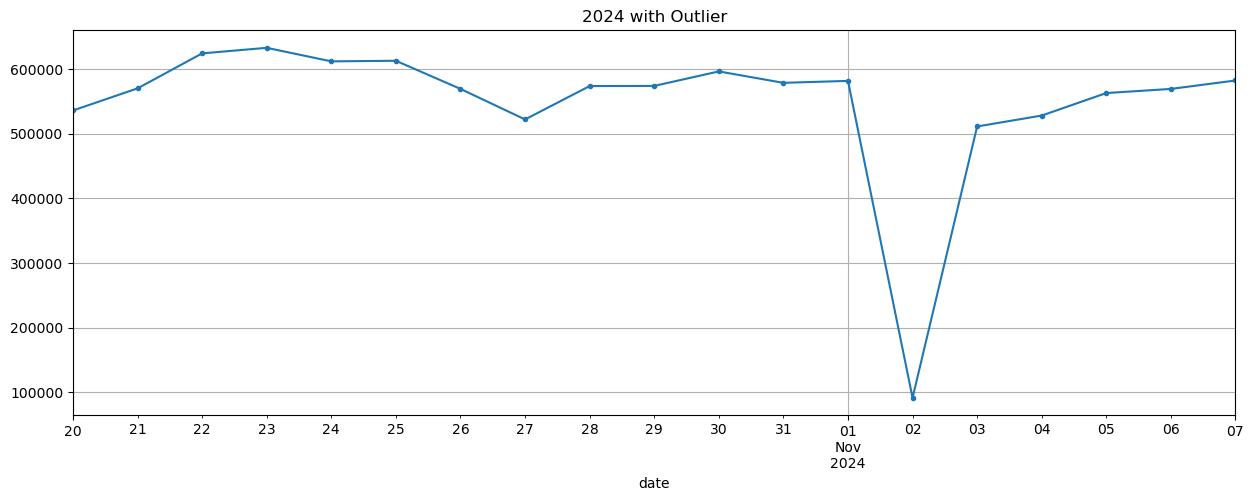

In [47]:
# Visualize the week of the outlier
df_merged['total_value'].loc['2024-10-20':'2024-11-07'].plot(figsize=(15,5), grid=True, marker=".", title='2024 with Outlier')

<Axes: title={'center': '2024 with Outlier Handled'}, xlabel='date'>

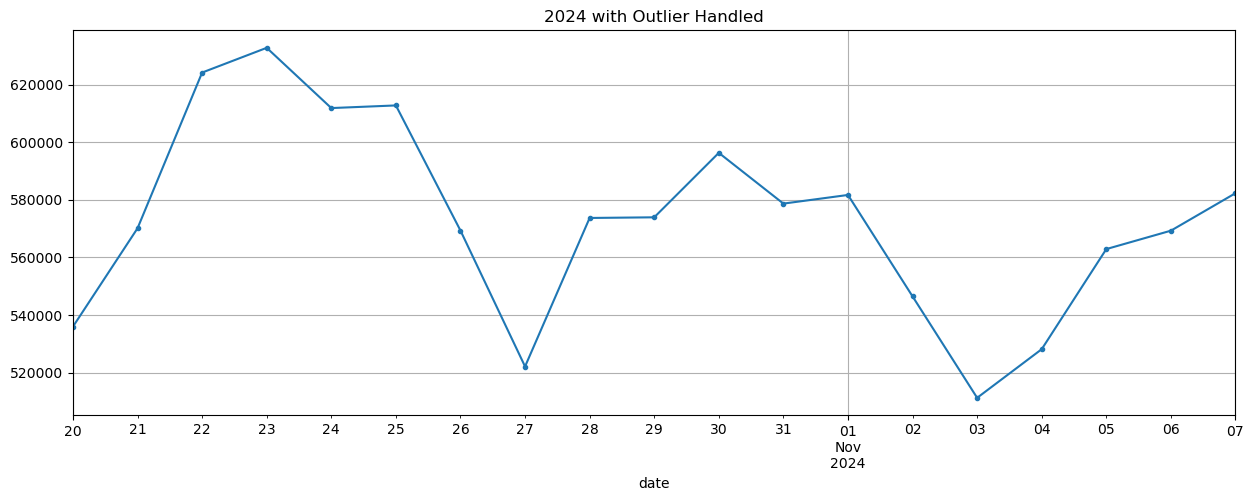

In [48]:
# We will use linear interpolation to handle the outlier
df_cleaned = df_merged.copy()
df_cleaned.loc[outlier_dates, 'total_value'] = np.nan
df_cleaned['total_value'] = df_cleaned['total_value'].interpolate(method='linear')
df_cleaned['total_value'].loc['2024-10-20':'2024-11-07'].plot(figsize=(15,5), grid=True, marker=".", title='2024 with Outlier Handled')

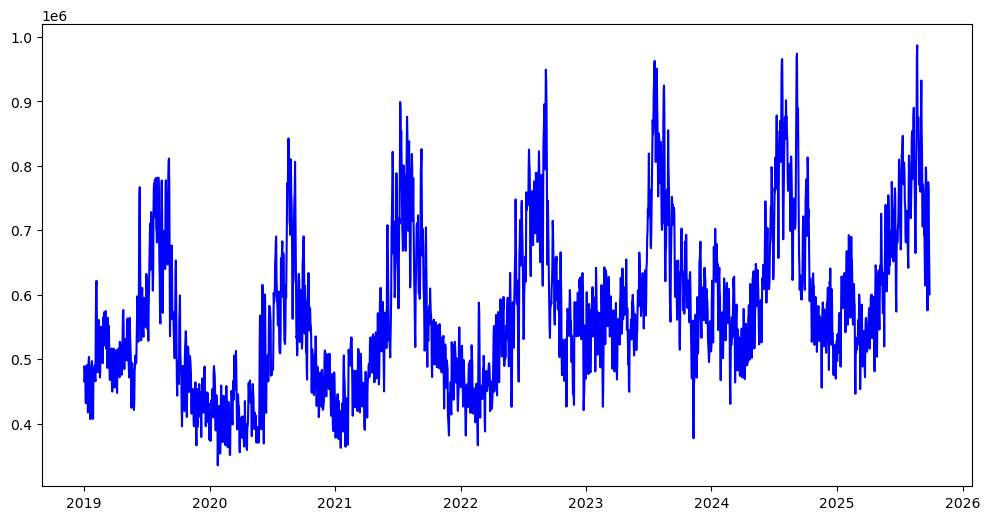

In [49]:
# Visualize the cleaned series
plt.figure(figsize=(12,6))
#plt.plot(df_merged.index, df_merged['total_value'], label='Original', color='blue', alpha=0.5)
plt.plot(df_cleaned.index, df_cleaned['total_value'], label='Cleaned', color='blue')


There appears to be yearly seasonality and an upwards/ increasing trend, lets zoom in to check for weekly, monthly seasonality

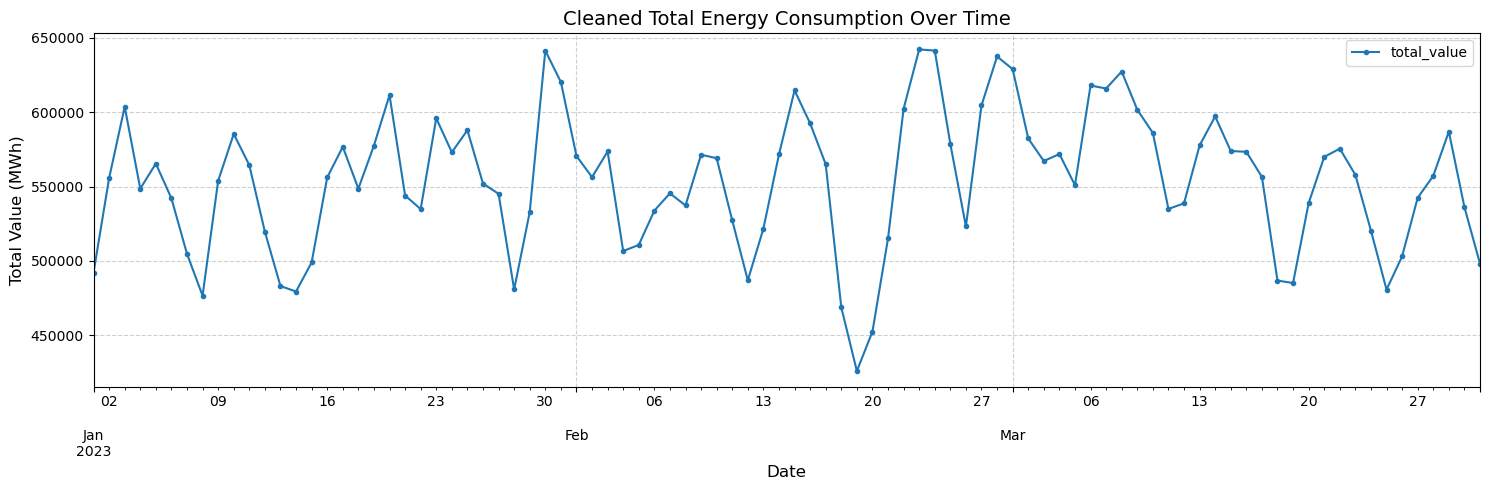

In [50]:
# Check for weekly seasonality for weeks jan 2023 to March 2023
df_cleaned['total_value'].loc['2023-01-01':'2023-03-31'].plot(figsize=(15,5), grid=True, marker=".", title='Jan to March 2023')
plt.title('Cleaned Total Energy Consumption Over Time', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Value (MWh)', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()



We can also observe a weekly pattern of oscillations as well

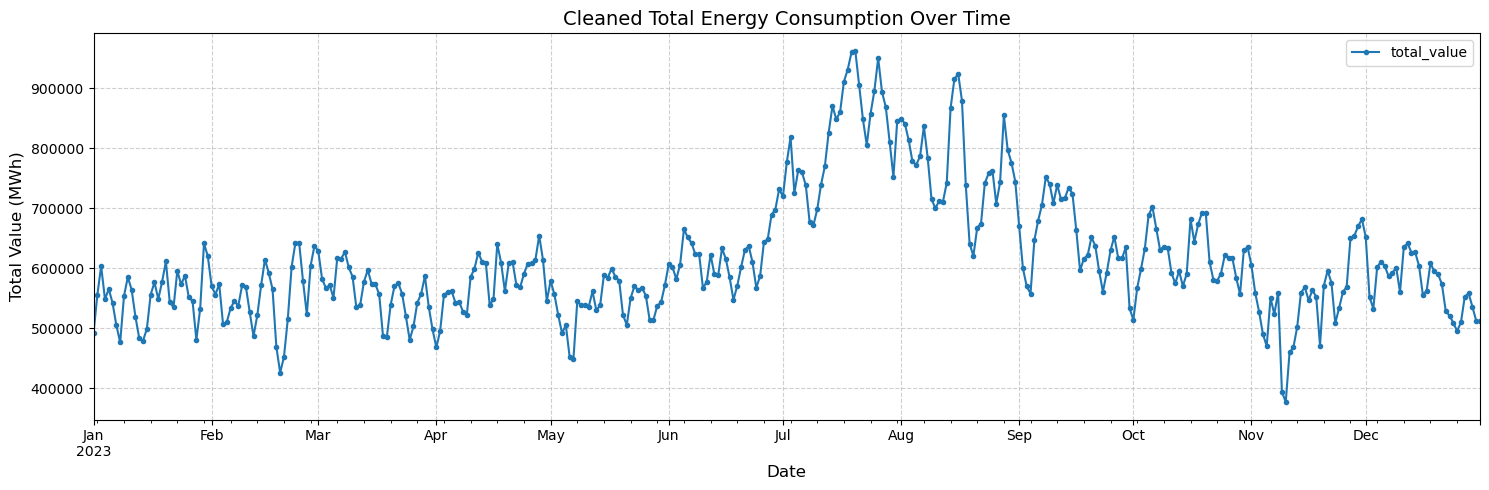

In [51]:
# check for monthly seasonality from Jan 2023 to Dec 2023
df_cleaned['total_value'].loc['2023-01-01':'2023-12-31'].plot(figsize=(15,5), grid=True, marker=".", title='Jan to Dec 2023')
plt.title('Cleaned Total Energy Consumption Over Time', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Value (MWh)', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

No clear pattern here either

In [52]:
# STL Decomposition
from statsmodels.tsa.seasonal import STL
stl = STL(df_cleaned['total_value'], seasonal=365)  # 365 for yearly seasonality
result = stl.fit()

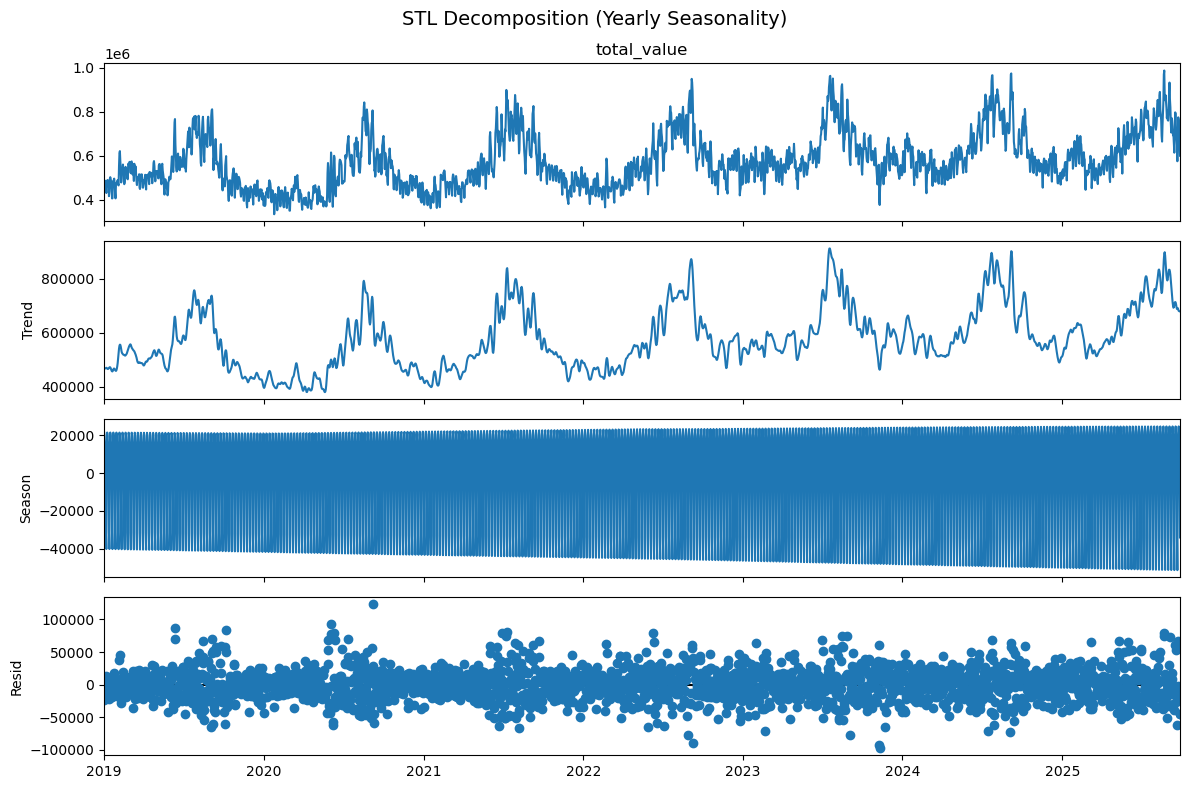

In [53]:
# Plot the decomposition
fig = result.plot()
fig.set_size_inches(12, 8)
fig.suptitle("STL Decomposition (Yearly Seasonality)", fontsize=14, y=0.98)
plt.tight_layout()
plt.show()

We will resample the data to monthly to visualize the seasonal component better

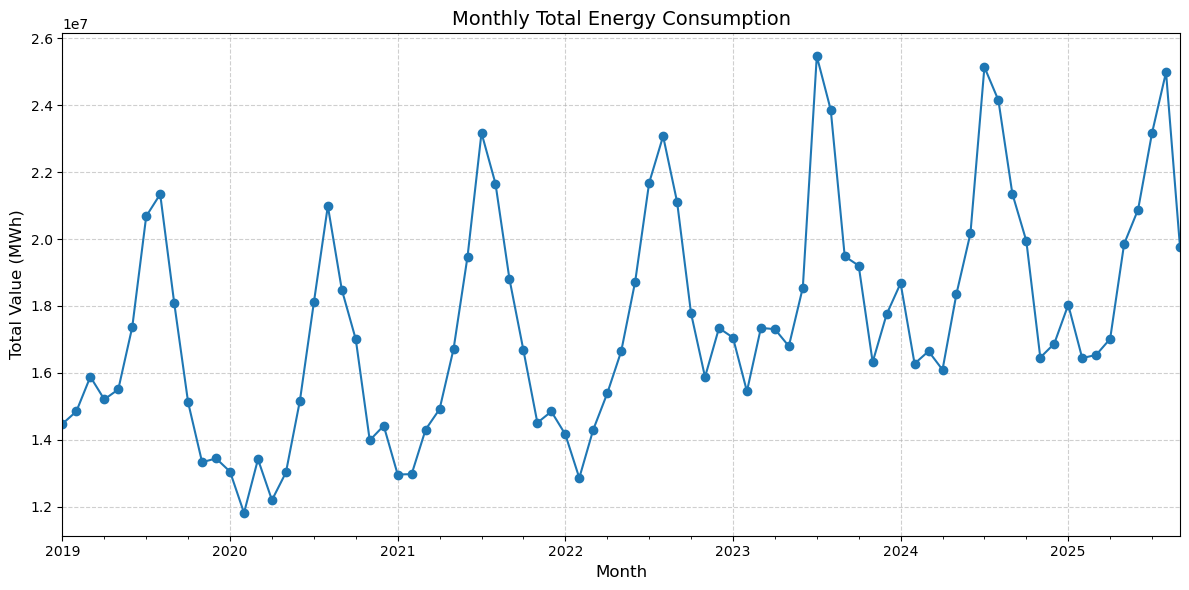

In [54]:
# Resample by month and sum values
df_monthly = df_cleaned['total_value'].resample('M').sum()
# plot monthly series
df_monthly.plot(figsize=(12,6), title='Monthly Total Energy Consumption', grid=True, marker="o")
plt.title('Monthly Total Energy Consumption', fontsize=14)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Total Value (MWh)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


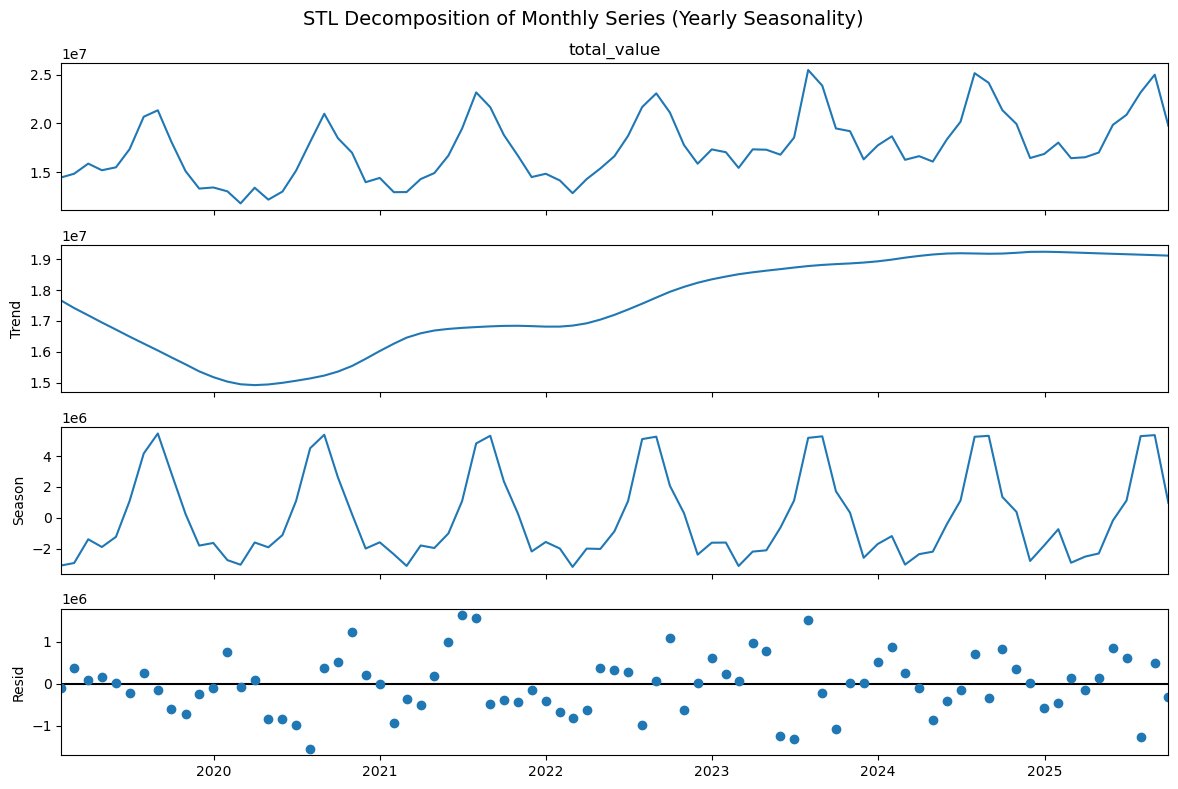

In [55]:
# Monthly STL Decomposition
stl_monthly = STL(df_monthly, seasonal=11)  # 12 for monthly seasonality
result_monthly = stl_monthly.fit()
# Plot the decomposition
fig = result_monthly.plot()
fig.set_size_inches(12, 8)
fig.suptitle("STL Decomposition of Monthly Series (Yearly Seasonality)", fontsize=14, y=0.98)
plt.tight_layout()
plt.show()


In [56]:
# Check for stationarity of cleaned series
from statsmodels.tsa.stattools import adfuller
result = adfuller(df_cleaned["total_value"])
print("ADF Statistic:", result[0])
print("p-value:", result[1])
for key, value in result[4].items():
    print(f"Critical Value {key}: {value}")
# p-value < 0.05 indicates stationarity


ADF Statistic: -2.9260539225175517
p-value: 0.04240108614273854
Critical Value 1%: -3.4330383807110296
Critical Value 5%: -2.8627276983827623
Critical Value 10%: -2.5674022602026403


The p - value for the Augmented Dickey_fuller test is less than 0.05. Therefore we reject the null hypothesis that the series is non - stationary. Lets confirm with the ACF plot

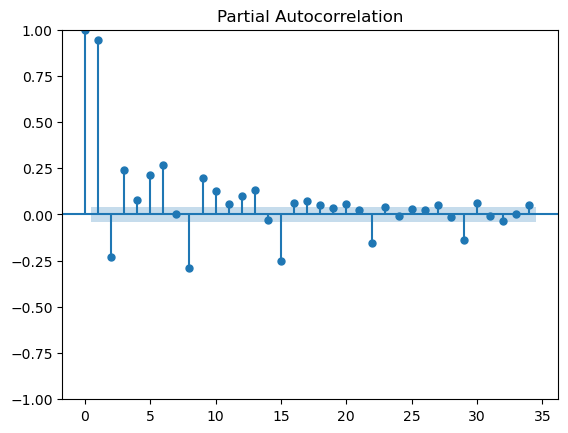

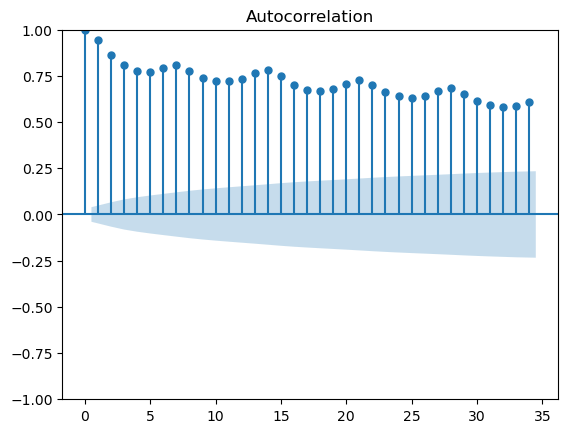

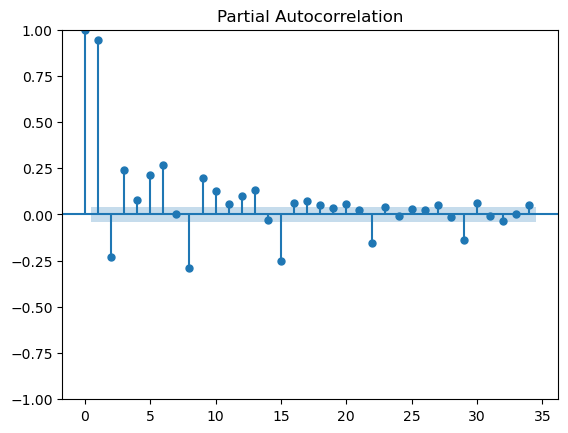

In [57]:
# ACF and PACF plots for cleaned series
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(df_cleaned["total_value"])
plot_pacf(df_cleaned["total_value"])


Based on the acf and pacf we should start with an Auto Regressive model with lags 1,2,3,7,9. Because we also see a upwards trend lets try differencing to detrend the series

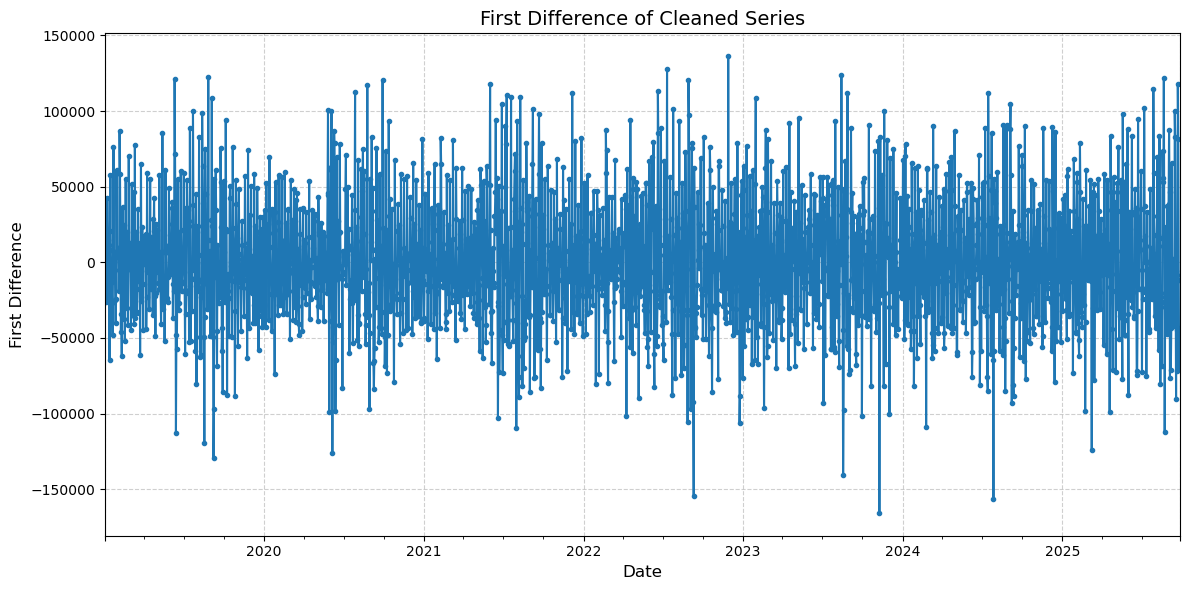

In [58]:
# Plot first difference sereis
first_diff = df_cleaned['total_value'].diff().dropna()
first_diff.plot(figsize=(12,6), title='First Difference of Cleaned Series', grid=True, marker=".")
plt.title('First Difference of Cleaned Series', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('First Difference', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

Here we see that by first differencing (d=1) we have removed the upwards trend

ADF Statistic (1st Diff): -10.464590842687151
p-value (1st Diff): 1.3318487846487258e-18
Critical Value 1% (1st Diff): -3.4330405929799293
Critical Value 5% (1st Diff): -2.862728675299008
Critical Value 10% (1st Diff): -2.5674027803295183


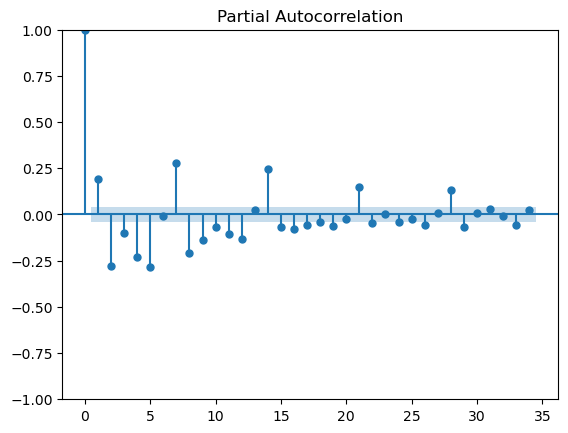

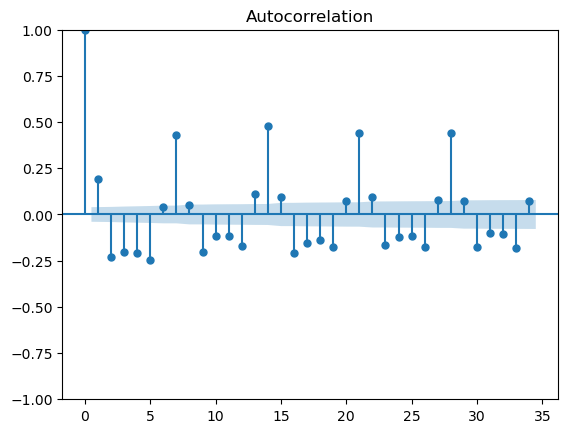

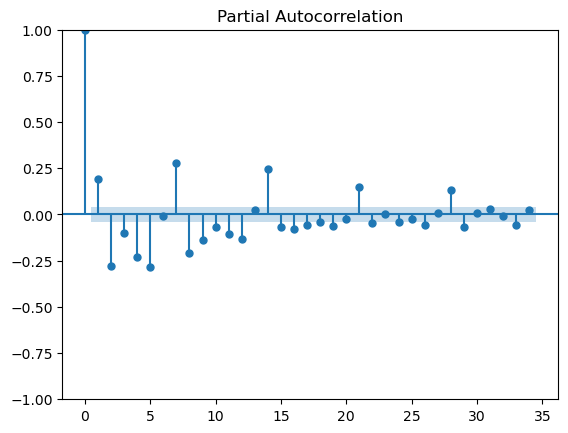

In [59]:
# ADF test on first difference
result = adfuller(first_diff)
print("ADF Statistic (1st Diff):", result[0])
print("p-value (1st Diff):", result[1])
for key, value in result[4].items():
    print(f"Critical Value {key} (1st Diff): {value}")
# p-value < 0.05 indicates stationarity of first difference
# ACF and PACF plots for first difference
plot_acf(first_diff)
plot_pacf(first_diff)



Here we see that we have a strong positive correlation at every 7 lags, indicating a strong weekly correlation.

# Modeling

Train shape: (1969,) Valid shape: (493,)


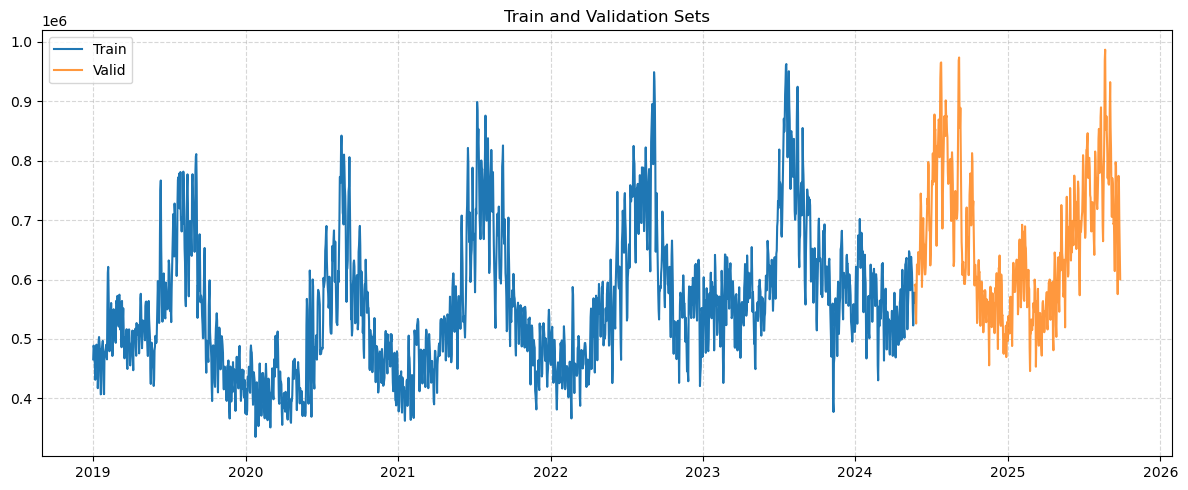

In [60]:
# Split cleaned data into train and validation sets
valid_frac = 0.2
n = len(df_cleaned)
k = int(np.floor((1 - valid_frac) * n))
y_tr, y_va = df_cleaned['total_value'].iloc[:k], df_cleaned['total_value'].iloc[k:]
print("Train shape:", y_tr.shape, "Valid shape:", y_va.shape)
# Plot the train and validation sets
plt.figure(figsize=(12,5))
plt.plot(y_tr.index, y_tr, label="Train")
plt.plot(y_va.index, y_va, label="Valid", alpha=0.8)
plt.title("Train and Validation Sets")
plt.legend(); plt.grid(True, linestyle="--", alpha=0.5); plt.tight_layout(); plt.show()


In [61]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(y_tr, order=(0,1,0), seasonal_order=(1,0,1,7))
model_fit = model.fit(disp=False)
print(model_fit.summary())


                                      SARIMAX Results                                      
Dep. Variable:                         total_value   No. Observations:                 1969
Model:             SARIMAX(0, 1, 0)x(1, 0, [1], 7)   Log Likelihood              -23106.090
Date:                             Tue, 04 Nov 2025   AIC                          46218.179
Time:                                     17:14:44   BIC                          46234.933
Sample:                                 01-01-2019   HQIC                         46224.336
                                      - 05-22-2024                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L7        0.9998      0.000   2367.213      0.000       0.999       1.001
ma.S.L7       -0.9921      

In [62]:
model2 = SARIMAX(y_tr, order=(1,1,1), seasonal_order=(1,1,1,7))
model2_fit = model2.fit(disp=False)
print(model2_fit.summary())

                                     SARIMAX Results                                     
Dep. Variable:                       total_value   No. Observations:                 1969
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood              -23132.797
Date:                           Tue, 04 Nov 2025   AIC                          46275.595
Time:                                   17:14:45   BIC                          46303.501
Sample:                               01-01-2019   HQIC                         46285.851
                                    - 05-22-2024                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1250      0.162     -0.772      0.440      -0.442       0.192
ma.L1          0.3374      0.152      2.225

Validation  MAE: 119,732.494   RMSE: 155,590.490


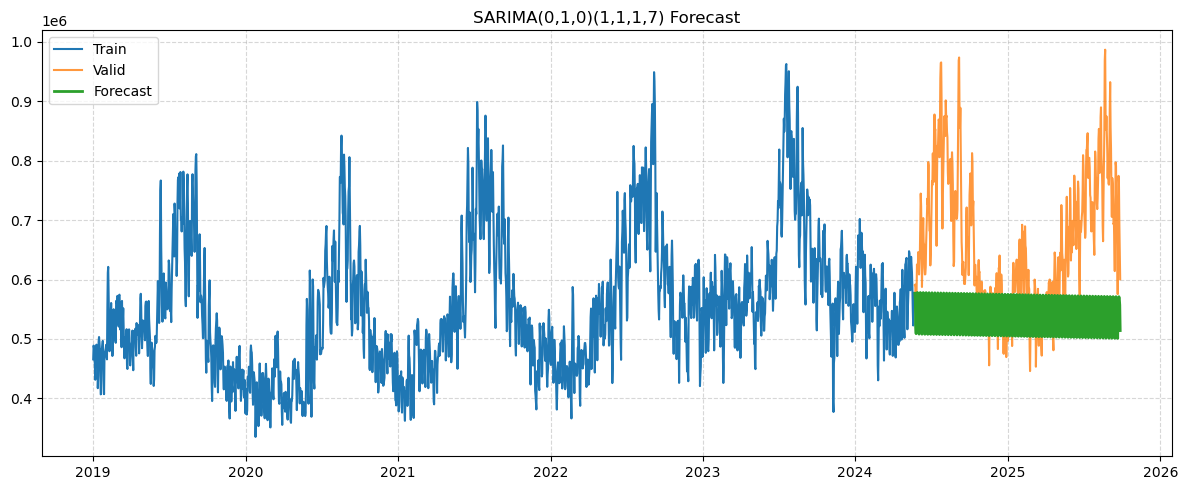

In [63]:
# get forecast for validation period
n_va = len(y_va)
y_hat = model2_fit.get_forecast(steps=n_va).predicted_mean
# Evaluate the forecast
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
mae = mean_absolute_error(y_va, y_hat)
rmse = sqrt(mean_squared_error(y_va, y_hat))
print(f"Validation  MAE: {mae:,.3f}   RMSE: {rmse:,.3f}")
# Plot the forecast vs actuals
plt.figure(figsize=(12,5))
plt.plot(y_tr.index, y_tr.values, label="Train")
plt.plot(y_va.index, y_va, label="Valid", alpha=0.8)
plt.plot(y_hat.index, y_hat, label="Forecast", linewidth=2)
plt.title("SARIMA(0,1,0)(1,1,1,7) Forecast")
plt.legend(); plt.grid(True, linestyle="--", alpha=0.5); plt.tight_layout(); plt.show()


It looks like the model failed to capture any relationships in the longer horizon, lets look a little closer at the immediate future

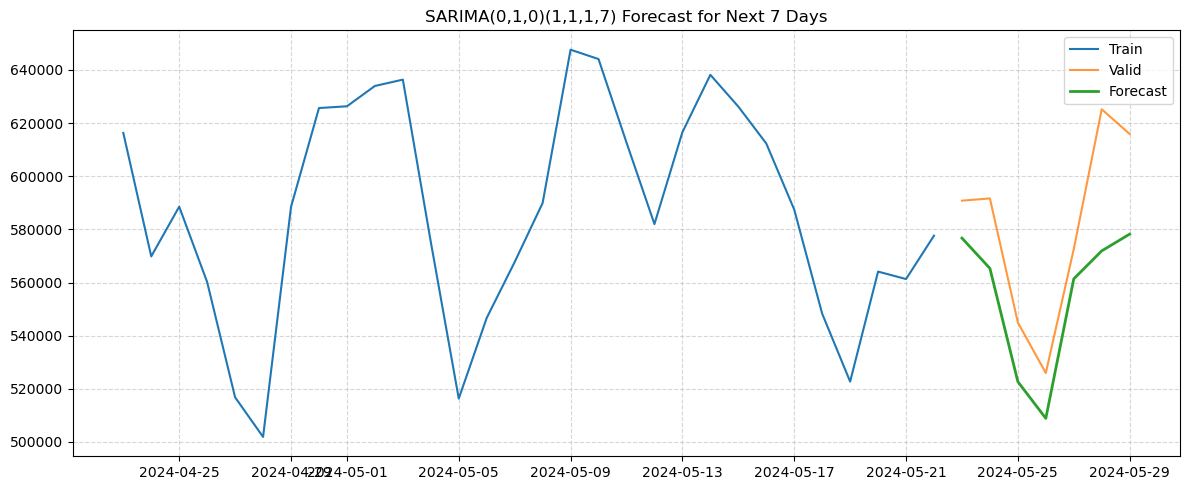

In [64]:
# Plot the forecast vs actuals for the next 7 days after the training set
plt.figure(figsize=(12,5))
plt.plot(y_tr.index[-30:], y_tr.values[-30:], label="Train")
plt.plot(y_va.index[:7], y_va[:7], label="Valid", alpha=0.8)
plt.plot(y_hat.index[:7], y_hat[:7], label="Forecast", linewidth=2)
plt.title("SARIMA(0,1,0)(1,1,1,7) Forecast for Next 7 Days")
plt.legend(); plt.grid(True, linestyle="--", alpha=0.5); plt.tight_layout(); plt.show()


Lets look at when the model starts falling off drastically

In [65]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.deterministic import Fourier

# Create Fourier object based on TRAINING index and desired period/order
fourier = Fourier(period=365, order=4)

# Training regressors
exog_train = fourier.in_sample(y_tr.index)

# Test/future regressors for the next len(x_test) points
exog_test = fourier.out_of_sample(index=y_va.index, steps=len(y_va))

# Fit model on training data
mod = SARIMAX(y_tr, order=(1,1,1), seasonal_order=(0,0,0,0), exog=exog_train)
res = mod.fit(disp=False)

# Forecast using the exog_test for future dates
forecast = res.forecast(steps=len(y_va), exog=exog_test)

Validation  MAE: 62,042.337   RMSE: 78,721.466


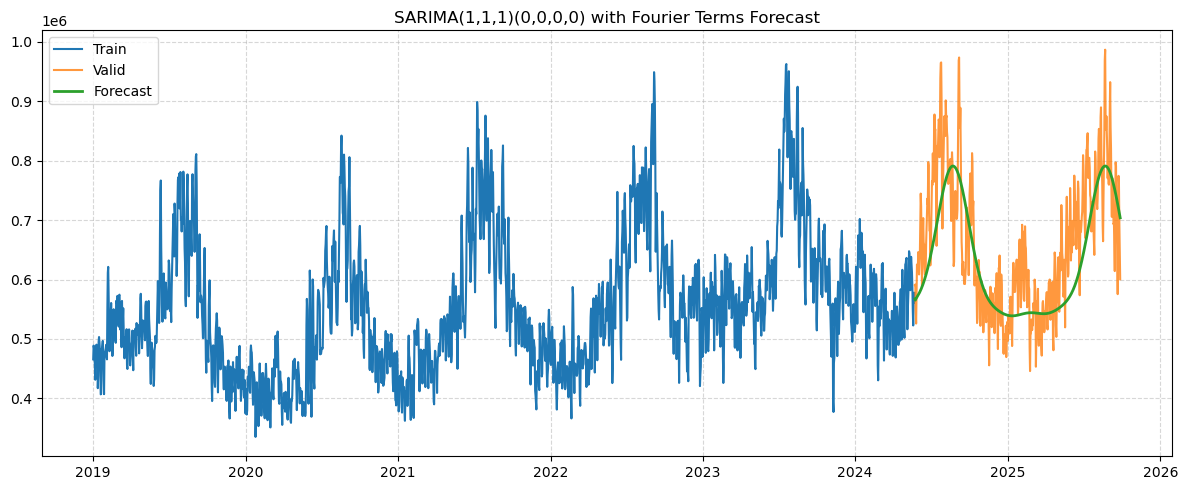

In [66]:
# Evaluate the forecast
mae = mean_absolute_error(y_va, forecast)
rmse = sqrt(mean_squared_error(y_va, forecast))
print(f"Validation  MAE: {mae:,.3f}   RMSE: {rmse:,.3f}")
# Plot the forecast vs actuals
plt.figure(figsize=(12,5))
plt.plot(y_tr.index, y_tr.values, label="Train")
plt.plot(y_va.index, y_va, label="Valid", alpha=0.8)
plt.plot(forecast.index, forecast, label="Forecast", linewidth=2)
plt.title("SARIMA(1,1,1)(0,0,0,0) with Fourier Terms Forecast")
plt.legend(); plt.grid(True, linestyle="--", alpha=0.5); plt.tight_layout(); plt.show() 

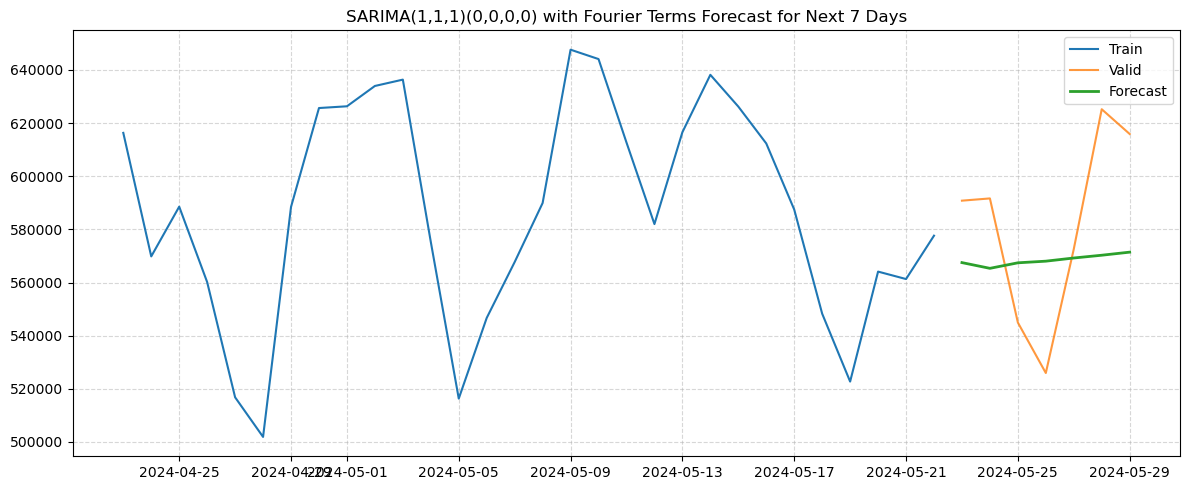

In [67]:
# Plot the forecast vs actuals for the next 7 days after the training set
plt.figure(figsize=(12,5))
plt.plot(y_tr.index[-30:], y_tr.values[-30:], label="Train")
plt.plot(y_va.index[:7], y_va[:7], label="Valid", alpha=0.8)
plt.plot(forecast.index[:7], forecast[:7], label="Forecast", linewidth=2)
plt.title("SARIMA(1,1,1)(0,0,0,0) with Fourier Terms Forecast for Next 7 Days")
plt.legend(); plt.grid(True, linestyle="--", alpha=0.5); plt.tight_layout(); plt.show()


In [68]:
# --- Import libraries ---
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [69]:
model = ExponentialSmoothing(
    y_tr,
    trend="add",         # or "mul" if trend grows multiplicatively
    seasonal="mul",      # or "add" for additive seasonality
    seasonal_periods=365  # one full year of seasonality
).fit()

Validation  MAE: 60,892.517   RMSE: 77,879.018


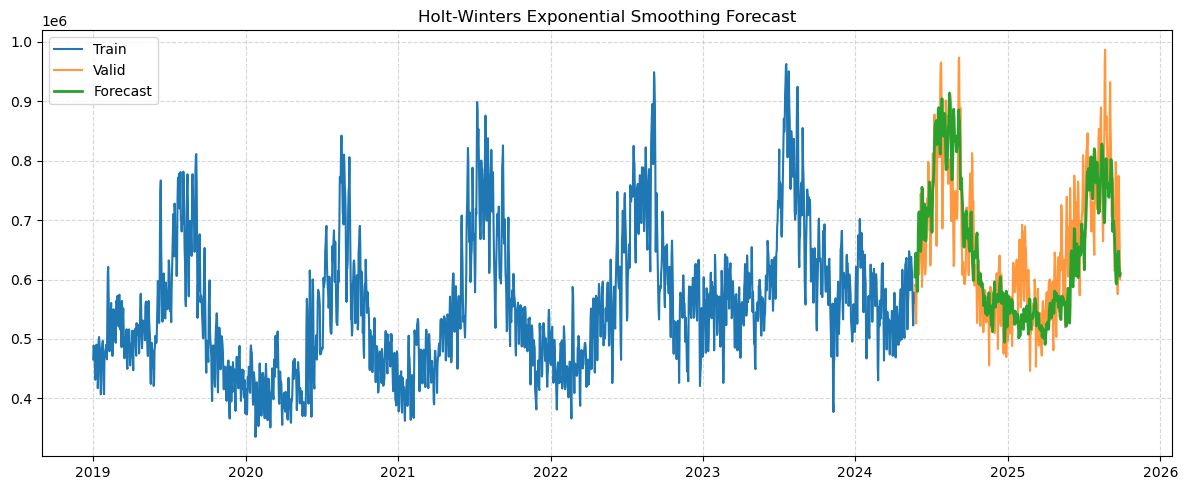

In [70]:
# Forecast
n_va = len(y_va)
y_hat = model.forecast(steps=n_va)
# Evaluate the forecast
mae = mean_absolute_error(y_va, y_hat)
rmse = sqrt(mean_squared_error(y_va, y_hat))
print(f"Validation  MAE: {mae:,.3f}   RMSE: {rmse:,.3f}")
# Plot the forecast vs actuals
plt.figure(figsize=(12,5))
plt.plot(y_tr.index, y_tr.values, label="Train")
plt.plot(y_va.index, y_va, label="Valid", alpha=0.8)
plt.plot(y_hat.index, y_hat, label="Forecast", linewidth=2)
plt.title("Holt-Winters Exponential Smoothing Forecast")
plt.legend(); plt.grid(True, linestyle="--", alpha=0.5); plt.tight_layout(); plt.show()


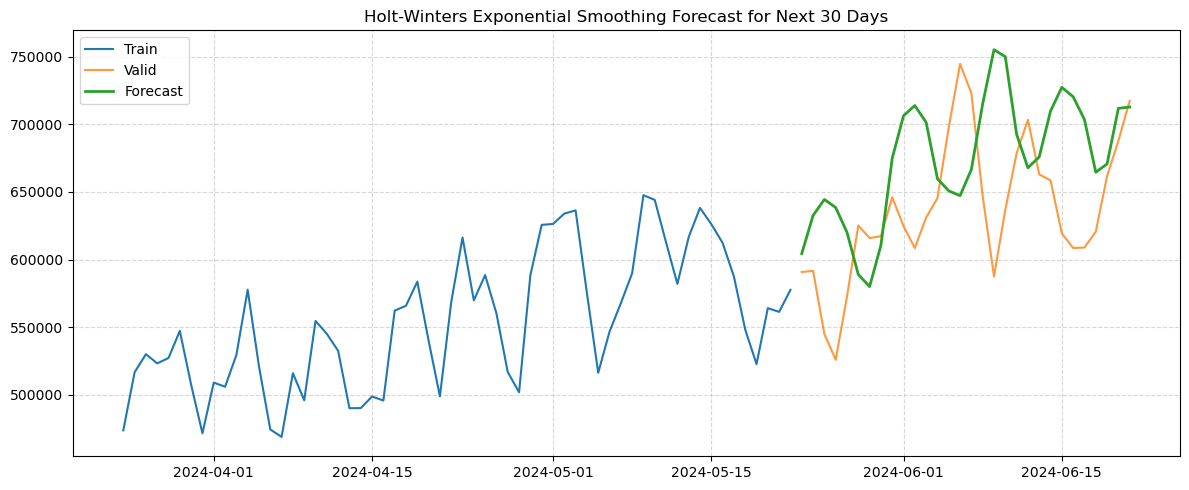

In [71]:
# Plot the forecast vs actuals for the next 30 days after the training set
plt.figure(figsize=(12,5))
plt.plot(y_tr.index[-60:], y_tr.values[-60:], label="Train")
plt.plot(y_va.index[:30], y_va[:30], label="Valid", alpha=0.8)
plt.plot(y_hat.index[:30], y_hat[:30], label="Forecast", linewidth=2)
plt.title("Holt-Winters Exponential Smoothing Forecast for Next 30 Days")
plt.legend(); plt.grid(True, linestyle="--", alpha=0.5); plt.tight_layout(); plt.show()




In [72]:
# Create  exogenous features
df_cleaned.head()

total_value  temperature_avg_c  precipitation_mm  wind_speed_kmh  \
date                                                                           
2019-01-01     465701.0                8.4               0.0             9.5   
2019-01-02     488901.0                8.9               0.0             5.3   
2019-01-03     484062.0               11.4               0.0             5.6   
2019-01-04     477305.0               12.3               0.0             6.4   
2019-01-05     451001.0               11.1               8.2             9.5   

            humidity_percent  pressure_hpa  7_day_avg  30_day_avg  
date                                                               
2019-01-01                22        1019.4        NaN         NaN  
2019-01-02                21        1022.4        NaN         NaN  
2019-01-03                30        1021.5        NaN         NaN  
2019-01-04                38        1016.5        NaN         NaN  
2019-01-05                78        1014.8        NaN         NaN

In [73]:
# delete 7_day_avg and 30_day_avg columns
df_cleaned.drop(columns=['7_day_avg', '30_day_avg'], inplace=True)
df_cleaned.head()

total_value  temperature_avg_c  precipitation_mm  wind_speed_kmh  \
date                                                                           
2019-01-01     465701.0                8.4               0.0             9.5   
2019-01-02     488901.0                8.9               0.0             5.3   
2019-01-03     484062.0               11.4               0.0             5.6   
2019-01-04     477305.0               12.3               0.0             6.4   
2019-01-05     451001.0               11.1               8.2             9.5   

            humidity_percent  pressure_hpa  
date                                        
2019-01-01                22        1019.4  
2019-01-02                21        1022.4  
2019-01-03                30        1021.5  
2019-01-04                38        1016.5  
2019-01-05                78        1014.8

In [74]:
# Add day of week and month as categorical variables
df_cleaned['day_of_week'] = df_cleaned.index.dayofweek
df_cleaned['month'] = df_cleaned.index.month
df_cleaned.head()

total_value  temperature_avg_c  precipitation_mm  wind_speed_kmh  \
date                                                                           
2019-01-01     465701.0                8.4               0.0             9.5   
2019-01-02     488901.0                8.9               0.0             5.3   
2019-01-03     484062.0               11.4               0.0             5.6   
2019-01-04     477305.0               12.3               0.0             6.4   
2019-01-05     451001.0               11.1               8.2             9.5   

            humidity_percent  pressure_hpa  day_of_week  month  
date                                                            
2019-01-01                22        1019.4            1      1  
2019-01-02                21        1022.4            2      1  
2019-01-03                30        1021.5            3      1  
2019-01-04                38        1016.5            4      1  
2019-01-05                78        1014.8            5      1

In [75]:
# Add is_weekend column
df_cleaned['is_weekend'] = df_cleaned['day_of_week'].isin([5, 6]).astype(int)
df_cleaned.head(10)

total_value  temperature_avg_c  precipitation_mm  wind_speed_kmh  \
date                                                                           
2019-01-01     465701.0                8.4               0.0             9.5   
2019-01-02     488901.0                8.9               0.0             5.3   
2019-01-03     484062.0               11.4               0.0             5.6   
2019-01-04     477305.0               12.3               0.0             6.4   
2019-01-05     451001.0               11.1               8.2             9.5   
2019-01-06     431380.0               11.7               2.6             8.1   
2019-01-07     473814.0               12.0               2.4            10.1   
2019-01-08     488715.0               14.1               0.0             6.5   
2019-01-09     490462.0               13.2               0.1             6.1   
2019-01-10     470146.0               12.6               0.0             5.7   

            humidity_percent  pressure_hpa  day_of_week  month  is_weekend  
date                                                                        
2019-01-01                22        1019.4            1      1           0  
2019-01-02                21        1022.4            2      1           0  
2019-01-03                30        1021.5            3      1           0  
2019-01-04                38        1016.5            4      1           0  
2019-01-05                78        1014.8            5      1           1  
2019-01-06                77        1019.1            6      1           1  
2019-01-07                82        1023.2            0      1           0  
2019-01-08                70        1019.7            1      1           0  
2019-01-09                76        1020.1            2      1           0  
2019-01-10                75        1019.9            3      1           0

In [76]:
# Check dtypes
df_cleaned.dtypes

total_value          float64
temperature_avg_c    float64
precipitation_mm     float64
wind_speed_kmh       float64
humidity_percent       int64
pressure_hpa         float64
day_of_week            int32
month                  int32
is_weekend             int64
dtype: object

In [77]:
## change day_of_week, month and weekend columns to categorical
df_cleaned['day_of_week'] = df_cleaned['day_of_week'].astype('category')
df_cleaned['month'] = df_cleaned['month'].astype('category')
df_cleaned['is_weekend'] = df_cleaned['is_weekend'].astype('category')
df_cleaned.dtypes

total_value           float64
temperature_avg_c     float64
precipitation_mm      float64
wind_speed_kmh        float64
humidity_percent        int64
pressure_hpa          float64
day_of_week          category
month                category
is_weekend           category
dtype: object

In [78]:
# Add a trend column to df_cleaned
df_cleaned = df_cleaned.reset_index()
df_cleaned['trend'] = np.arange(len(df_cleaned))
df_cleaned = df_cleaned.set_index('date')
df_cleaned.head()

total_value  temperature_avg_c  precipitation_mm  wind_speed_kmh  \
date                                                                           
2019-01-01     465701.0                8.4               0.0             9.5   
2019-01-02     488901.0                8.9               0.0             5.3   
2019-01-03     484062.0               11.4               0.0             5.6   
2019-01-04     477305.0               12.3               0.0             6.4   
2019-01-05     451001.0               11.1               8.2             9.5   

            humidity_percent  pressure_hpa day_of_week month is_weekend  trend  
date                                                                            
2019-01-01                22        1019.4           1     1          0      0  
2019-01-02                21        1022.4           2     1          0      1  
2019-01-03                30        1021.5           3     1          0      2  
2019-01-04                38        1016.5           4     1          0      3  
2019-01-05                78        1014.8           5     1          1      4

In [105]:
# get dummies for categorical variables
df_final = pd.get_dummies(df_cleaned, drop_first=True, dtype=int)
df_final.head()

total_value  temperature_avg_c  precipitation_mm  wind_speed_kmh  \
date                                                                           
2019-01-01     465701.0                8.4               0.0             9.5   
2019-01-02     488901.0                8.9               0.0             5.3   
2019-01-03     484062.0               11.4               0.0             5.6   
2019-01-04     477305.0               12.3               0.0             6.4   
2019-01-05     451001.0               11.1               8.2             9.5   

            humidity_percent  pressure_hpa  trend  day_of_week_1  \
date                                                               
2019-01-01                22        1019.4      0              1   
2019-01-02                21        1022.4      1              0   
2019-01-03                30        1021.5      2              0   
2019-01-04                38        1016.5      3              0   
2019-01-05                78        1014.8      4              0   

            day_of_week_2  day_of_week_3  ...  month_4  month_5  month_6  \
date                                      ...                              
2019-01-01              0              0  ...        0        0        0   
2019-01-02              1              0  ...        0        0        0   
2019-01-03              0              1  ...        0        0        0   
2019-01-04              0              0  ...        0        0        0   
2019-01-05              0              0  ...        0        0        0   

            month_7  month_8  month_9  month_10  month_11  month_12  \
date                                                                  
2019-01-01        0        0        0         0         0         0   
2019-01-02        0        0        0         0         0         0   
2019-01-03        0        0        0         0         0         0   
2019-01-04        0        0        0         0         0         0   
2019-01-05        0        0        0         0         0         0   

            is_weekend_1  
date                      
2019-01-01             0  
2019-01-02             0  
2019-01-03             0  
2019-01-04             0  
2019-01-05             1  

[5 rows x 25 columns]

In [106]:
# Add lag features for weekly and yearly lags
df_final['lag_7'] = df_final['total_value'].shift(7)
df_final['lag_365'] = df_final['total_value'].shift(365)
df_final.head(15)

total_value  temperature_avg_c  precipitation_mm  wind_speed_kmh  \
date                                                                           
2019-01-01     465701.0                8.4               0.0             9.5   
2019-01-02     488901.0                8.9               0.0             5.3   
2019-01-03     484062.0               11.4               0.0             5.6   
2019-01-04     477305.0               12.3               0.0             6.4   
2019-01-05     451001.0               11.1               8.2             9.5   
2019-01-06     431380.0               11.7               2.6             8.1   
2019-01-07     473814.0               12.0               2.4            10.1   
2019-01-08     488715.0               14.1               0.0             6.5   
2019-01-09     490462.0               13.2               0.1             6.1   
2019-01-10     470146.0               12.6               0.0             5.7   
2019-01-11     481587.0               12.5               0.0             7.3   
2019-01-12     417211.0               11.1              16.1             9.6   
2019-01-13     437955.0               10.8               0.0             7.3   
2019-01-14     495428.0               10.9              29.3            12.8   
2019-01-15     503286.0               10.9              11.0            13.4   

            humidity_percent  pressure_hpa  trend  day_of_week_1  \
date                                                               
2019-01-01                22        1019.4      0              1   
2019-01-02                21        1022.4      1              0   
2019-01-03                30        1021.5      2              0   
2019-01-04                38        1016.5      3              0   
2019-01-05                78        1014.8      4              0   
2019-01-06                77        1019.1      5              0   
2019-01-07                82        1023.2      6              0   
2019-01-08                70        1019.7      7              1   
2019-01-09                76        1020.1      8              0   
2019-01-10                75        1019.9      9              0   
2019-01-11                83        1017.8     10              0   
2019-01-12                86        1016.9     11              0   
2019-01-13                77        1017.7     12              0   
2019-01-14                79        1016.3     13              0   
2019-01-15                82        1017.1     14              1   

            day_of_week_2  day_of_week_3  ...  month_6  month_7  month_8  \
date                                      ...                              
2019-01-01              0              0  ...        0        0        0   
2019-01-02              1              0  ...        0        0        0   
2019-01-03              0              1  ...        0        0        0   
2019-01-04              0              0  ...        0        0        0   
2019-01-05              0              0  ...        0        0        0   
2019-01-06              0              0  ...        0        0        0   
2019-01-07              0              0  ...        0        0        0   
2019-01-08              0              0  ...        0        0        0   
2019-01-09              1              0  ...        0        0        0   
2019-01-10              0              1  ...        0        0        0   
2019-01-11              0              0  ...        0        0        0   
2019-01-12              0              0  ...        0        0        0   
2019-01-13              0              0  ...        0        0        0   
2019-01-14              0              0  ...        0        0        0   
2019-01-15              0              0  ...        0        0        0   

            month_9  month_10  month_11  month_12  is_weekend_1     lag_7  \
date                                                                        
2019-01-01        0         0         0        

In [107]:
# split the last 20% as validation set
valid_frac = 0.2
n = len(df_final)
k = int(np.floor((1 - valid_frac) * n))
train_df, valid_df = df_final.iloc[:k], df_final.iloc[k:]
print("Train shape:", train_df.shape, "Valid shape:", valid_df.shape)
# Separate features and target
X_tr = train_df.drop(columns=['total_value'])
y_tr = train_df['total_value']
X_va = valid_df.drop(columns=['total_value'])
y_va = valid_df['total_value']
print("X_tr shape:", X_tr.shape, "y_tr shape:", y_tr.shape)

Train shape: (1969, 27) Valid shape: (493, 27)
X_tr shape: (1969, 26) y_tr shape: (1969,)


In [108]:
X_tr.dtypes

temperature_avg_c    float64
precipitation_mm     float64
wind_speed_kmh       float64
humidity_percent       int64
pressure_hpa         float64
trend                  int64
day_of_week_1          int64
day_of_week_2          int64
day_of_week_3          int64
day_of_week_4          int64
day_of_week_5          int64
day_of_week_6          int64
month_2                int64
month_3                int64
month_4                int64
month_5                int64
month_6                int64
month_7                int64
month_8                int64
month_9                int64
month_10               int64
month_11               int64
month_12               int64
is_weekend_1           int64
lag_7                float64
lag_365              float64
dtype: object

In [109]:
# Standardize features
scaler = StandardScaler()
# Split categorical and numerical columns
num_cols = ['temperature_avg_c', 'precipitation_mm', 'wind_speed_kmh', 'humidity_percent', 'pressure_hpa', 'lag_7', 'lag_365']
X_tr[num_cols] = scaler.fit_transform(X_tr[num_cols])
X_va[num_cols] = scaler.transform(X_va[num_cols])

In [110]:
X_tr.head(20)

temperature_avg_c  precipitation_mm  wind_speed_kmh  \
date                                                              
2019-01-01          -1.847364         -0.226102        0.487292   
2019-01-02          -1.742669         -0.226102       -1.213838   
2019-01-03          -1.219191         -0.226102       -1.092329   
2019-01-04          -1.030738         -0.226102       -0.768304   
2019-01-05          -1.282008          0.996798        0.487292   
2019-01-06          -1.156373          0.161647       -0.079751   
2019-01-07          -1.093556          0.131820        0.730311   
2019-01-08          -0.653834         -0.226102       -0.727801   
2019-01-09          -0.842286         -0.211189       -0.889813   
2019-01-10          -0.967921         -0.226102       -1.051826   
2019-01-11          -0.988860         -0.226102       -0.403776   
2019-01-12          -1.282008          2.174958        0.527795   
2019-01-13          -1.344825         -0.226102       -0.403776   
2019-01-14          -1.323886          4.143528        1.823894   
2019-01-15          -1.323886          1.414373        2.066913   
2019-01-16          -0.779469          4.128615        1.864397   
2019-01-17          -0.611956          4.471623        1.135342   
2019-01-18          -1.030738         -0.226102       -0.525285   
2019-01-19          -0.591017         -0.226102       -1.659372   
2019-01-20          -0.528200         -0.226102       -1.092329   

            humidity_percent  pressure_hpa  trend  day_of_week_1  \
date                                                               
2019-01-01         -2.443707      1.141859      0              1   
2019-01-02         -2.502390      1.942714      1              0   
2019-01-03         -1.974243      1.702457      2              0   
2019-01-04         -1.504778      0.367699      3              0   
2019-01-05          0.842545     -0.086119      4              0   
2019-01-06          0.783862      1.061773      5              0   
2019-01-07          1.077277      2.156275      6              0   
2019-01-08          0.373080      1.221944      7              1   
2019-01-09          0.725178      1.328725      8              0   
2019-01-10          0.666495      1.275335      9              0   
2019-01-11          1.135960      0.714736     10              0   
2019-01-12          1.312009      0.474480     11              0   
2019-01-13          0.783862      0.688041     12              0   
2019-01-14          0.901228      0.314309     13              0   
2019-01-15          1.077277      0.527870     14              1   
2019-01-16          1.664108      1.515591     15              0   
2019-01-17          1.898840      1.595676     16              0   
2019-01-18          1.488058      2.316446     17              0   
2019-01-19          0.431763      2.049494     18              0   
2019-01-20          0.314397      0.661346     19              0   

            day_of_week_2  day_of_week_3  day_of_week_4  ...  month_6  \
date                                                     ...            
2019-01-01              0              0              0  ...        0   
2019-01-02              1              0              0  ...        0   
2019-01-03              0              1              0  ...        0   
2019-01-04              0              0              1  ...        0   
2019-01-05              0              0              0  ...        0   
2019-01-06              0              0              0  ...        0   
2019-01-07              0              0              0  ...        0   
2019-01-08              0              0              0  ...        0   
2019-01-09              1              0              0  ...        0   
2019-01-10              0              1              0  ...        0   
2019-01-11              0              0              1  ...        0   
2019-01-12              0              0              0  ...        0   
2019-01-13        

In [111]:
X_va.head(20)

temperature_avg_c  precipitation_mm  wind_speed_kmh  \
date                                                              
2024-05-23          -0.151296         -0.196275        0.527795   
2024-05-24          -0.214113         -0.196275        0.082261   
2024-05-25          -0.214113         -0.226102        1.702385   
2024-05-26          -0.130356         -0.226102        0.406286   
2024-05-27          -0.130356         -0.226102        0.284776   
2024-05-28          -0.109417         -0.226102        0.163267   
2024-05-29          -0.067539         -0.226102        0.203770   
2024-05-30           0.120913         -0.226102        0.082261   
2024-05-31          -0.025661         -0.226102        0.001255   
2024-06-01          -0.130356         -0.226102       -0.444279   
2024-06-02           0.079035         -0.226102        0.041758   
2024-06-03           0.162791         -0.226102        0.001255   
2024-06-04           0.393122         -0.226102       -0.079751   
2024-06-05           0.393122         -0.226102        0.001255   
2024-06-06           0.414061         -0.226102        0.082261   
2024-06-07           0.372182         -0.226102        0.203770   
2024-06-08           0.351243         -0.226102        0.649304   
2024-06-09           0.309365         -0.211189        0.001255   
2024-06-10           0.162791         -0.226102       -0.160758   
2024-06-11           0.120913         -0.226102       -0.201261   

            humidity_percent  pressure_hpa  trend  day_of_week_1  \
date                                                               
2024-05-23          0.373080     -0.459851   1969              0   
2024-05-24          0.549129     -0.539936   1970              0   
2024-05-25          0.197031     -0.032728   1971              0   
2024-05-26          0.431763      0.207528   1972              0   
2024-05-27          0.607812      0.341004   1973              0   
2024-05-28          0.607812      0.421089   1974              1   
2024-05-29          0.490446      0.234223   1975              0   
2024-05-30          0.490446     -0.433156   1976              0   
2024-05-31          0.725178     -0.726803   1977              0   
2024-06-01          0.666495     -0.620022   1978              0   
2024-06-02          0.373080     -0.620022   1979              0   
2024-06-03          0.549129     -0.967059   1980              0   
2024-06-04          0.490446     -1.234011   1981              1   
2024-06-05          0.725178     -0.993754   1982              0   
2024-06-06          0.783862     -1.020449   1983              0   
2024-06-07          0.725178     -0.833583   1984              0   
2024-06-08          0.490446     -0.539936   1985              0   
2024-06-09          0.373080     -0.353070   1986              0   
2024-06-10          0.725178     -0.566632   1987              0   
2024-06-11          0.842545     -0.726803   1988              1   

            day_of_week_2  day_of_week_3  day_of_week_4  ...  month_6  \
date                                                     ...            
2024-05-23              0              1              0  ...        0   
2024-05-24              0              0              1  ...        0   
2024-05-25              0              0              0  ...        0   
2024-05-26              0              0              0  ...        0   
2024-05-27              0              0              0  ...        0   
2024-05-28              0              0              0  ...        0   
2024-05-29              1              0              0  ...        0   
2024-05-30              0              1              0  ...        0   
2024-05-31              0              0              1  ...        0   
2024-06-01              0              0              0  ...        1   
2024-06-02              0              0              0  ...        1   
2024-06-03              0              0              0  ...        1   
2024-06-04        

In [112]:
# Drop rows with NaN values (due to lag features)
X_tr.dropna(inplace=True)
# Align y_tr accordingly
y_tr = y_tr.loc[X_tr.index]
X_tr.shape, y_tr.shape

((1604, 26), (1604,))

In [190]:
# Grid search multiple regression models
from sklearn.linear_model import LinearRegression, Ridge, Lasso
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
import xgboost as xgb
from sklearn.linear_model import LinearRegression, Ridge, Lasso

# Define models
models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "XGBRegressor": xgb.XGBRegressor(
        objective='reg:squarederror',
        eval_metric='rmse',
        use_label_encoder=False,
        random_state=42
    )
}

# Define parameter grids
params = {
    "LinearRegression": {},
    "Ridge": {"alpha": [0.1, 1.0, 10.0]},
    "Lasso": {"alpha": [0.01, 0.1, 1.0]},
    "XGBRegressor": {
        "n_estimators": [100, 200, 300],
        "max_depth": [3, 5, 7],
        "learning_rate": [0.01, 0.1]
    }
}

# Use time-based splits (not random)
tscv = TimeSeriesSplit(n_splits=10, test_size=None)

results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")

    # Grid search with time series CV
    grid = GridSearchCV(
        estimator=model,
        param_grid=params[name],
        cv=tscv,
        scoring='neg_mean_absolute_error',
        n_jobs=-1
    )
    
    grid.fit(X_tr, y_tr)

    best_model = grid.best_estimator_

    # Predict on *validation set* (hold-out set, not in CV)
    y_pred = best_model.predict(X_va)

    mae = mean_absolute_error(y_va, y_pred)
    rmse = sqrt(mean_squared_error(y_va, y_pred))

    results[name] = {
        "best_params": grid.best_params_,
        "mae": mae,
        "rmse": rmse
    }

    print(f"{name} - Best Params: {grid.best_params_}, MAE: {mae:.3f}, RMSE: {rmse:.3f}")



Training LinearRegression...
LinearRegression - Best Params: {}, MAE: 52848.328, RMSE: 64043.516

Training Ridge...
Ridge - Best Params: {'alpha': 0.1}, MAE: 52808.315, RMSE: 64000.906

Training Lasso...


/opt/anaconda3/envs/myproject_env/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.232e+09, tolerance: 2.480e+07
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/myproject_env/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.955e+11, tolerance: 3.754e+08
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/myproject_env/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider

Lasso - Best Params: {'alpha': 1.0}, MAE: 52843.478, RMSE: 64038.050

Training XGBRegressor...


/opt/anaconda3/envs/myproject_env/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [22:03:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/myproject_env/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [22:03:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/myproject_env/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [22:03:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/myproject_env/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [22:03:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Paramet

XGBRegressor - Best Params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}, MAE: 42627.312, RMSE: 56243.488


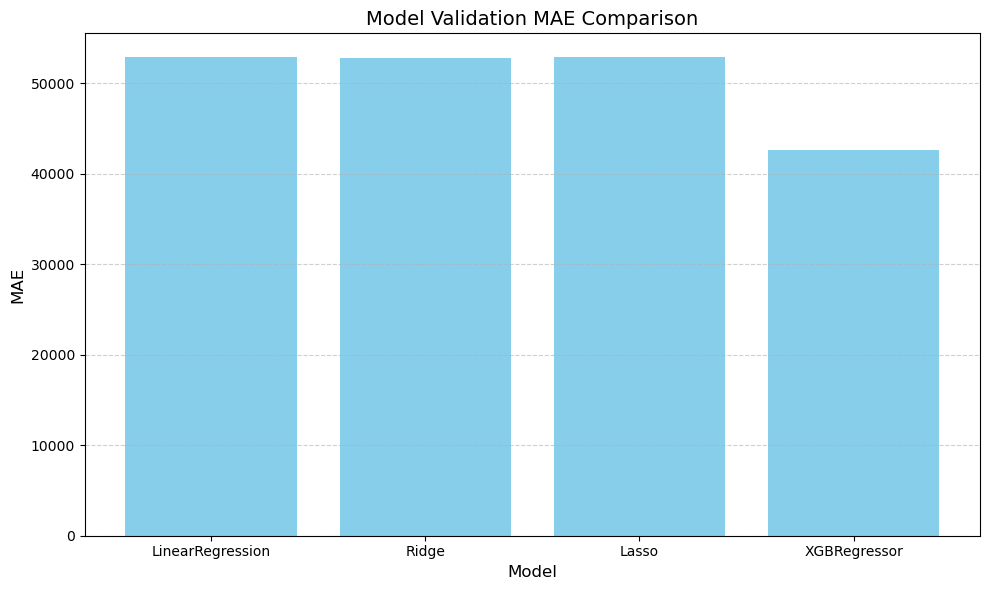

In [191]:
# Plot validation results
plt.figure(figsize=(10,6))
model_names = list(results.keys())
mae_values = [results[name]['mae'] for name in model_names]
plt.bar(model_names, mae_values, color='skyblue')
plt.title('Model Validation MAE Comparison', fontsize=14)
plt.xlabel('Model', fontsize=12)
plt.ylabel('MAE', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


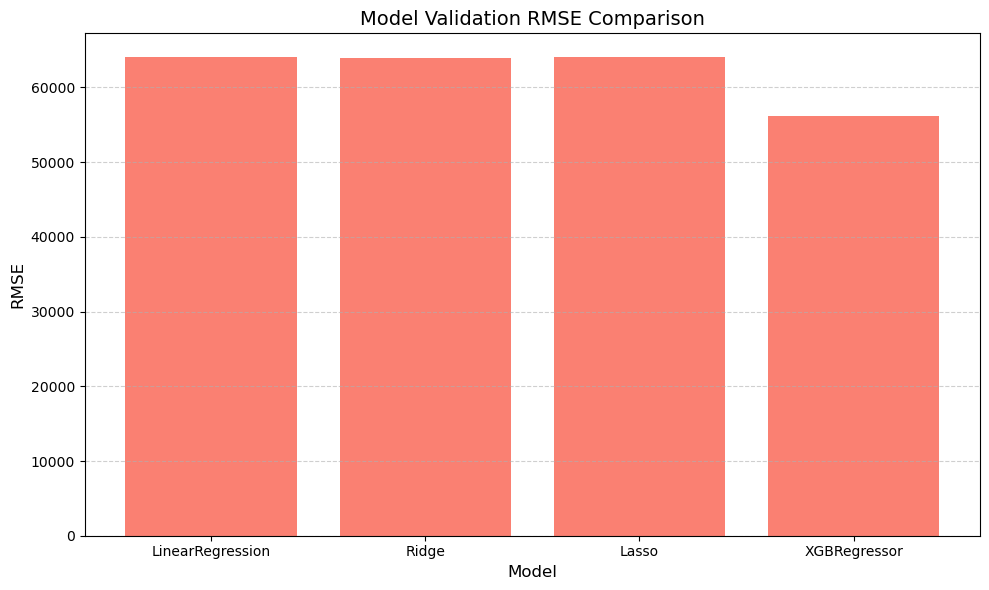

In [192]:
# Plot validation results RMSE
plt.figure(figsize=(10,6))
model_names = list(results.keys())
rmse_values = [results[name]['rmse'] for name in model_names]
plt.bar(model_names, rmse_values, color='salmon')
plt.title('Model Validation RMSE Comparison', fontsize=14)
plt.xlabel('Model', fontsize=12)
plt.ylabel('RMSE', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


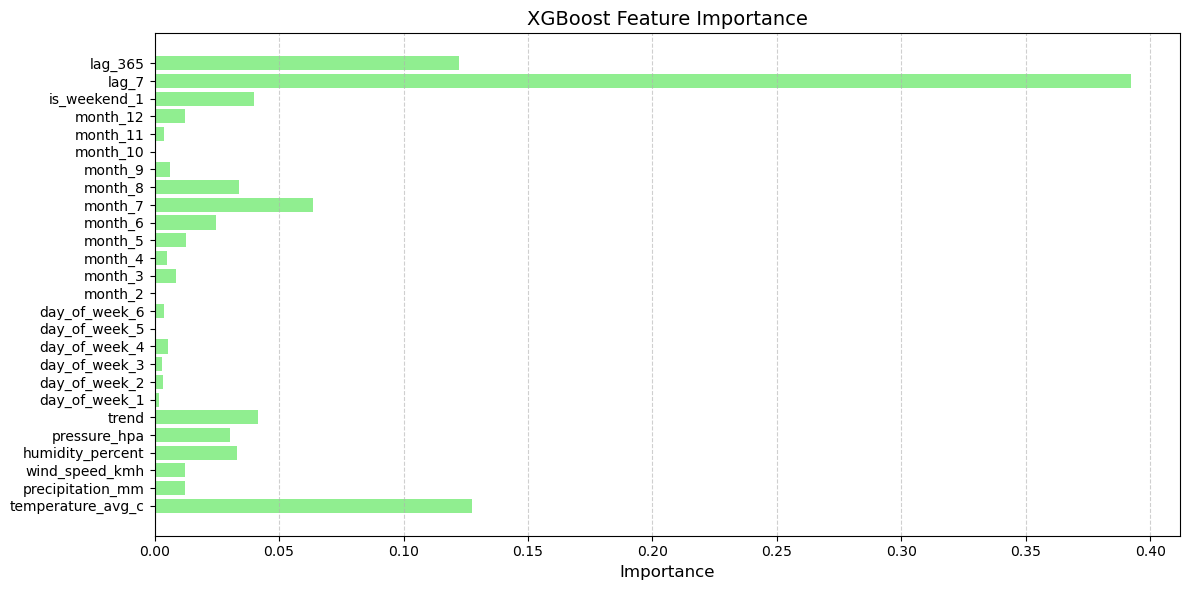

In [193]:
# Plot XGBoost feature importance
xgb_model = models["XGBRegressor"].set_params(**results["XGBRegressor"]["best_params"])
xgb_model.fit(X_tr, y_tr)
importances = xgb_model.feature_importances_
feature_names = X_tr.columns
plt.figure(figsize=(12,6))
plt.barh(feature_names, importances, color='lightgreen')
plt.title('XGBoost Feature Importance', fontsize=14)
plt.xlabel('Importance', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


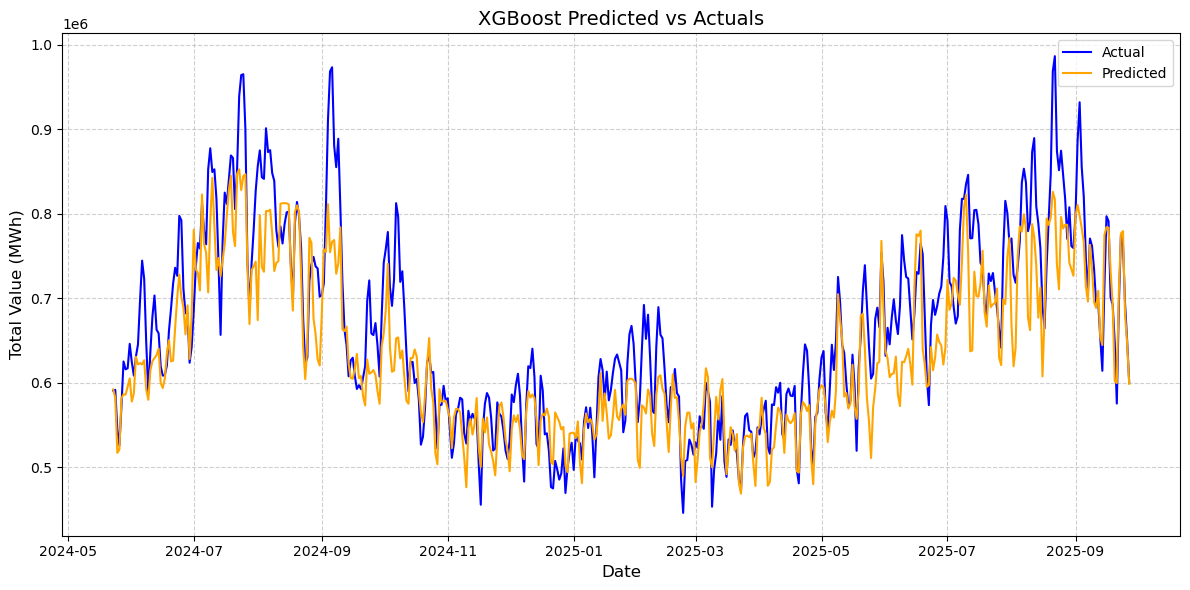

In [194]:
# plot XGBoost predicted vs actuals
y_pred = xgb_model.predict(X_va)
plt.figure(figsize=(12,6))
plt.plot(y_va.index, y_va, label='Actual', color='blue')
plt.plot(y_va.index, y_pred, label='Predicted', color='orange')
plt.title('XGBoost Predicted vs Actuals', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Value (MWh)', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()



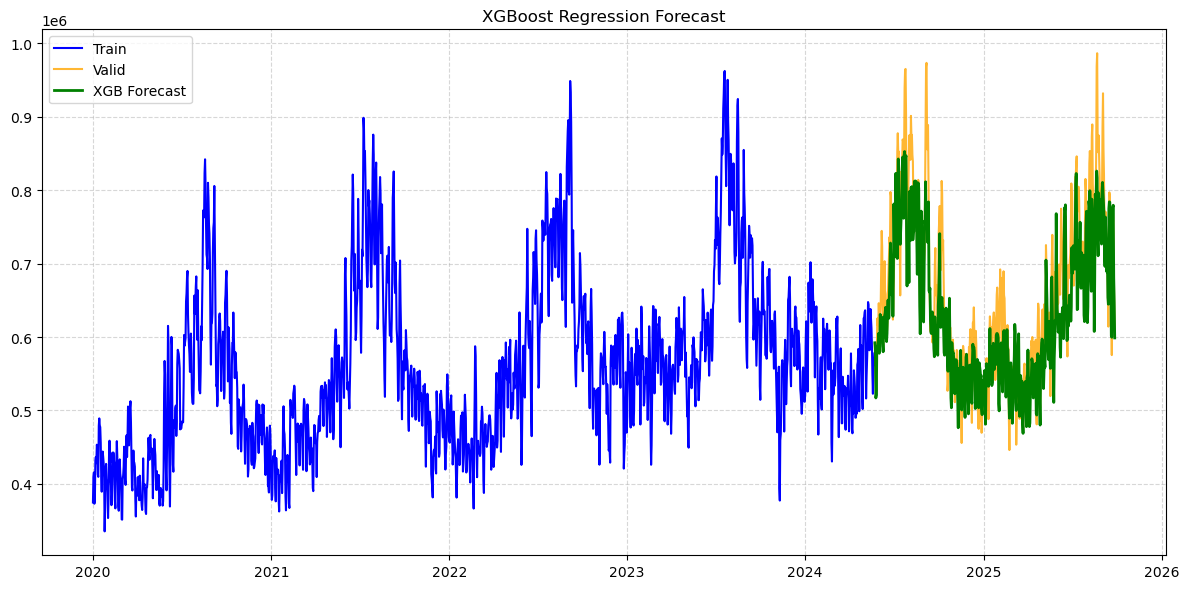

In [195]:
# Plot training and validation sets with predictions
plt.figure(figsize=(12,6))
plt.plot(y_tr.index, y_tr, label="Train", color='blue')
plt.plot(y_va.index, y_va, label="Valid", color='orange', alpha=0.8)
plt.plot(y_va.index, y_pred, label="XGB Forecast", color='green', linewidth=2)
plt.title("XGBoost Regression Forecast")
plt.legend(); plt.grid(True, linestyle="--", alpha=0.5); plt.tight_layout(); plt.show()

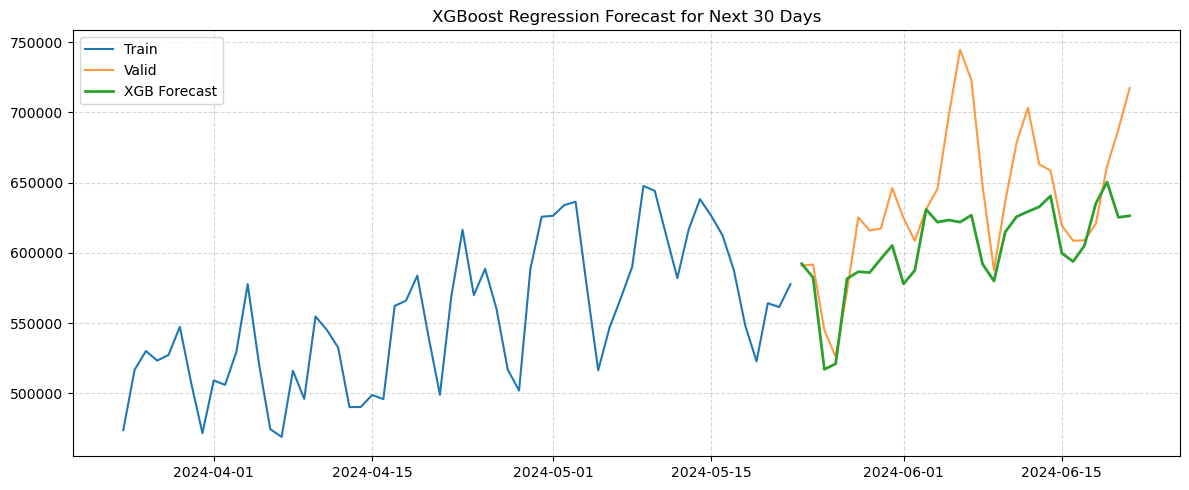

In [196]:
# Plot the forecast vs actuals for the next 30 days after the training set
plt.figure(figsize=(12,5))
plt.plot(y_tr.index[-60:], y_tr.values[-60:], label="Train")
plt.plot(y_va.index[:30], y_va[:30], label="Valid", alpha=0.8)
plt.plot(y_va.index[:30], y_pred[:30], label="XGB Forecast", linewidth=2)
plt.title("XGBoost Regression Forecast for Next 30 Days")
plt.legend(); plt.grid(True, linestyle="--", alpha=0.5); plt.tight_layout(); plt.show()


In [120]:
df_final.head()

total_value  temperature_avg_c  precipitation_mm  wind_speed_kmh  \
date                                                                           
2019-01-01     465701.0                8.4               0.0             9.5   
2019-01-02     488901.0                8.9               0.0             5.3   
2019-01-03     484062.0               11.4               0.0             5.6   
2019-01-04     477305.0               12.3               0.0             6.4   
2019-01-05     451001.0               11.1               8.2             9.5   

            humidity_percent  pressure_hpa  trend  day_of_week_1  \
date                                                               
2019-01-01                22        1019.4      0              1   
2019-01-02                21        1022.4      1              0   
2019-01-03                30        1021.5      2              0   
2019-01-04                38        1016.5      3              0   
2019-01-05                78        1014.8      4              0   

            day_of_week_2  day_of_week_3  ...  month_6  month_7  month_8  \
date                                      ...                              
2019-01-01              0              0  ...        0        0        0   
2019-01-02              1              0  ...        0        0        0   
2019-01-03              0              1  ...        0        0        0   
2019-01-04              0              0  ...        0        0        0   
2019-01-05              0              0  ...        0        0        0   

            month_9  month_10  month_11  month_12  is_weekend_1  lag_7  \
date                                                                     
2019-01-01        0         0         0         0             0    NaN   
2019-01-02        0         0         0         0             0    NaN   
2019-01-03        0         0         0         0             0    NaN   
2019-01-04        0         0         0         0             0    NaN   
2019-01-05        0         0         0         0             1    NaN   

            lag_365  
date                 
2019-01-01      NaN  
2019-01-02      NaN  
2019-01-03      NaN  
2019-01-04      NaN  
2019-01-05      NaN  

[5 rows x 27 columns]

## Forecasting one week ahead

In [121]:
df_cleaned.head()

total_value  temperature_avg_c  precipitation_mm  wind_speed_kmh  \
date                                                                           
2019-01-01     465701.0                8.4               0.0             9.5   
2019-01-02     488901.0                8.9               0.0             5.3   
2019-01-03     484062.0               11.4               0.0             5.6   
2019-01-04     477305.0               12.3               0.0             6.4   
2019-01-05     451001.0               11.1               8.2             9.5   

            humidity_percent  pressure_hpa day_of_week month is_weekend  trend  
date                                                                            
2019-01-01                22        1019.4           1     1          0      0  
2019-01-02                21        1022.4           2     1          0      1  
2019-01-03                30        1021.5           3     1          0      2  
2019-01-04                38        1016.5           4     1          0      3  
2019-01-05                78        1014.8           5     1          1      4

In [132]:
def sarimax_rolling_origin_cv_with_holdout(data, exog_data=None, order=(1,1,1), 
                                          seasonal_order=(1,1,1,7), horizon=7, 
                                          min_train_size=365, step=7, 
                                          holdout_size=7, verbose=True):
    """
    Rolling Origin CV for SARIMAX with built-in final holdout set
    
    Parameters:
    - holdout_size: number of samples to hold out at the end for final evaluation
    """
    
    # Split data: hold out the last `holdout_size` samples
    data_cv = data.iloc[:-holdout_size]
    data_holdout = data.iloc[-holdout_size:]
    
    if exog_data is not None:
        exog_cv = exog_data.iloc[:-holdout_size]
        exog_holdout = exog_data.iloc[-holdout_size:]
    else:
        exog_cv = None
        exog_holdout = None
    
    values = data_cv.values
    n_samples = len(values)
    
    # Generate splits on CV data (excluding holdout)
    splits = []
    train_start = 0
    
    while train_start + min_train_size + horizon <= n_samples:
        train_end = train_start + min_train_size
        test_start = train_end
        test_end = test_start + horizon
        
        splits.append(((train_start, train_end), (test_start, test_end)))
        train_start += step
    
    # Cross-validation results
    cv_results = []
    all_forecasts = []
    
    for i, (train_idx, test_idx) in enumerate(splits):
        train_start, train_end = train_idx
        test_start, test_end = test_idx
        
        train_data = data_cv.iloc[train_start:train_end]
        test_data = data_cv.iloc[test_start:test_end]
        
        if exog_data is not None:
            exog_train = exog_cv.iloc[train_start:train_end]
            exog_test = exog_cv.iloc[test_start:test_end]
        else:
            exog_train = None
            exog_test = None
        
        try:
            model = SARIMAX(train_data,
                          exog=exog_train,
                          order=order,
                          seasonal_order=seasonal_order,
                          enforce_stationarity=False,
                          enforce_invertibility=False)
            
            model_fit = model.fit(disp=False)
            forecast = model_fit.get_forecast(steps=horizon, exog=exog_test)
            forecast_values = forecast.predicted_mean
            
            mae = mean_absolute_error(test_data, forecast_values)
            rmse = np.sqrt(mean_squared_error(test_data, forecast_values))
            mape = np.mean(np.abs((test_data - forecast_values) / test_data)) * 100
            
            result = {
                'fold': i + 1,
                'train_start': data_cv.index[train_start],
                'train_end': data_cv.index[train_end - 1],
                'test_start': data_cv.index[test_start],
                'test_end': data_cv.index[test_end - 1],
                'mae': mae,
                'rmse': rmse,
                'mape': mape,
                'aic': model_fit.aic
            }
            cv_results.append(result)
            
            if verbose:
                print(f"CV Fold {i+1}: MAE: {mae:.2f}, MAPE: {mape:.2f}%")
                
        except Exception as e:
            print(f"Error in CV fold {i+1}: {e}")
            continue
    
    # FINAL HOLDOUT EVALUATION
    print(f"\n{'='*50}")
    print("FINAL HOLDOUT EVALUATION")
    print(f"{'='*50}")
    
    # Train final model on entire CV dataset
    final_model = SARIMAX(data_cv,
                         exog=exog_cv,
                         order=order,
                         seasonal_order=seasonal_order,
                         enforce_stationarity=False,
                         enforce_invertibility=False)
    
    final_model_fit = final_model.fit(disp=False)
    
    # Forecast on holdout set
    holdout_forecast = final_model_fit.get_forecast(steps=holdout_size, exog=exog_holdout)
    holdout_values = holdout_forecast.predicted_mean
    holdout_ci = holdout_forecast.conf_int()
    
    # Calculate holdout metrics
    holdout_mae = mean_absolute_error(data_holdout, holdout_values)
    holdout_rmse = np.sqrt(mean_squared_error(data_holdout, holdout_values))
    holdout_mape = np.mean(np.abs((data_holdout - holdout_values) / data_holdout)) * 100
    
    holdout_result = {
        'holdout_mae': holdout_mae,
        'holdout_rmse': holdout_rmse,
        'holdout_mape': holdout_mape,
        'holdout_start': data_holdout.index[0],
        'holdout_end': data_holdout.index[-1]
    }
    
    print(f"Holdout Period: {data_holdout.index[0].date()} to {data_holdout.index[-1].date()}")
    print(f"Holdout MAE: {holdout_mae:.2f}")
    print(f"Holdout RMSE: {holdout_rmse:.2f}")
    print(f"Holdout MAPE: {holdout_mape:.2f}%")
    
    # Compare with CV performance
    cv_mae_avg = np.mean([r['mae'] for r in cv_results])
    cv_mape_avg = np.mean([r['mape'] for r in cv_results])
    
    print(f"\nCV Average MAE: {cv_mae_avg:.2f}")
    print(f"CV Average MAPE: {cv_mape_avg:.2f}%")
    print(f"Holdout/CV MAE Ratio: {holdout_mae/cv_mae_avg:.2f}")
    
    return (pd.DataFrame(cv_results), holdout_result, 
            final_model_fit, holdout_values, data_holdout)
  # Hold out the last 7 days

In [125]:
df_sarimax = df_cleaned[['total_value']]

In [126]:
df_sarimax.head()

total_value
date                   
2019-01-01     465701.0
2019-01-02     488901.0
2019-01-03     484062.0
2019-01-04     477305.0
2019-01-05     451001.0

In [127]:
df_sarimax.values

array([[465701.],
       [488901.],
       [484062.],
       ...,
       [693233.],
       [650032.],
       [600388.]], shape=(2462, 1))

In [128]:
df_exog = df_cleaned[['temperature_avg_c']]
df_exog.head()

temperature_avg_c
date                         
2019-01-01                8.4
2019-01-02                8.9
2019-01-03               11.4
2019-01-04               12.3
2019-01-05               11.1

In [144]:
# Usage
print("Running SARIMAX CV with Holdout...")
cv_results, holdout_result, final_model, holdout_forecast, holdout_actual = sarimax_rolling_origin_cv_with_holdout(
    df_sarimax['total_value'], 
    exog_data = df_exog, 
    order=(1,1,1), 
    seasonal_order=(1,1,1,7),
    horizon=7,
    min_train_size=365,
    step=14,
    holdout_size=7)

Running SARIMAX CV with Holdout...
CV Fold 1: MAE: 41485.11, MAPE: 10.15%
CV Fold 2: MAE: 52663.53, MAPE: 12.41%
CV Fold 3: MAE: 31961.43, MAPE: 7.65%
CV Fold 4: MAE: 34658.49, MAPE: 8.46%
CV Fold 5: MAE: 15500.45, MAPE: 3.88%
CV Fold 6: MAE: 37473.25, MAPE: 7.84%
CV Fold 7: MAE: 26643.97, MAPE: 6.93%
CV Fold 8: MAE: 16520.73, MAPE: 4.18%
CV Fold 9: MAE: 29663.56, MAPE: 6.55%
CV Fold 10: MAE: 8823.16, MAPE: 2.08%
CV Fold 11: MAE: 27386.59, MAPE: 6.04%
CV Fold 12: MAE: 52722.28, MAPE: 10.93%
CV Fold 13: MAE: 82499.89, MAPE: 15.94%
CV Fold 14: MAE: 61124.47, MAPE: 10.86%
CV Fold 15: MAE: 60823.65, MAPE: 10.57%
CV Fold 16: MAE: 42452.26, MAPE: 6.53%
CV Fold 17: MAE: 156869.32, MAPE: 20.26%
CV Fold 18: MAE: 97604.23, MAPE: 15.97%
CV Fold 19: MAE: 96021.05, MAPE: 17.86%
CV Fold 20: MAE: 25265.65, MAPE: 4.14%
CV Fold 21: MAE: 30574.95, MAPE: 5.92%
CV Fold 22: MAE: 40122.36, MAPE: 8.21%
CV Fold 23: MAE: 33499.89, MAPE: 7.08%
CV Fold 24: MAE: 38989.06, MAPE: 8.41%
CV Fold 25: MAE: 17291.42, MA

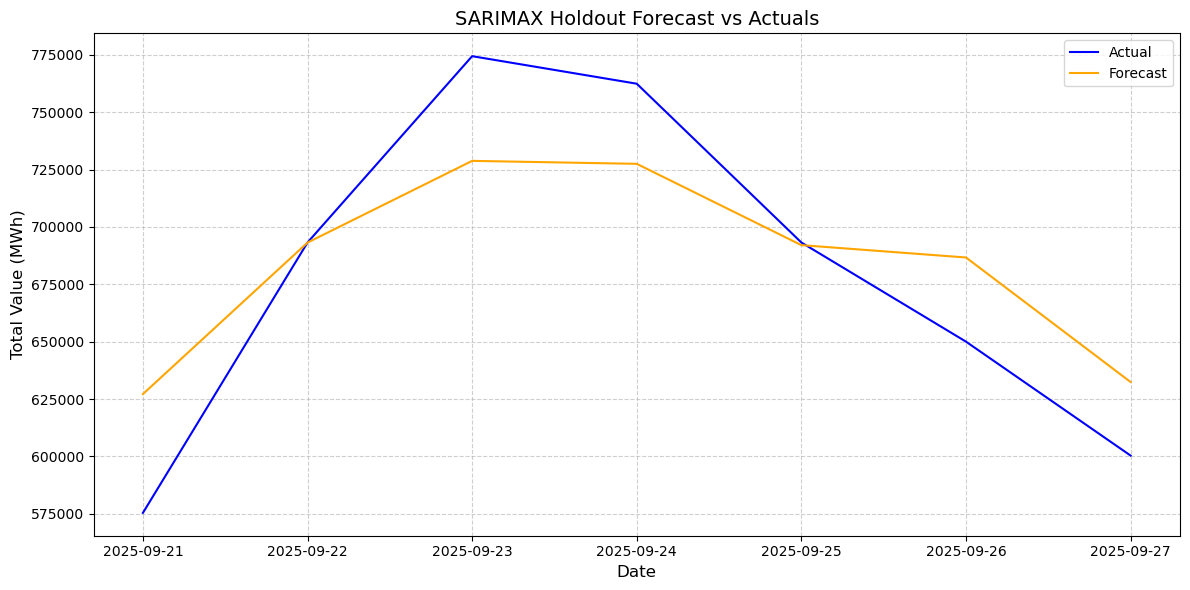

In [145]:
# Plot holdout forecast vs actuals
plt.figure(figsize=(12,6))
plt.plot(holdout_actual.index, holdout_actual, label='Actual', color='blue')
plt.plot(holdout_forecast.index, holdout_forecast, label='Forecast', color='orange')
plt.title('SARIMAX Holdout Forecast vs Actuals', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Value (MWh)', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


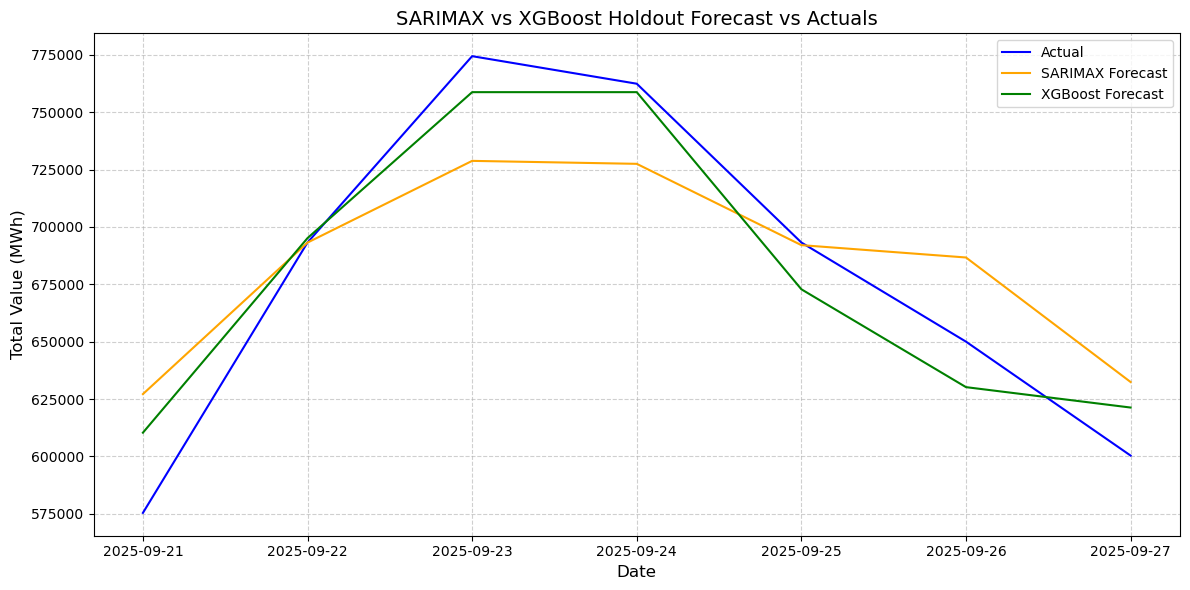

In [140]:
# Compare with holdout predictions from XGBoost
y_pred_xgb = xgb_model.predict(X_va.tail(7))
plt.figure(figsize=(12,6))
plt.plot(holdout_actual.index, holdout_actual, label='Actual', color='blue')
plt.plot(holdout_forecast.index, holdout_forecast, label='SARIMAX Forecast', color='orange')
plt.plot(holdout_actual.index, y_pred_xgb, label='XGBoost Forecast', color='green')
plt.title('SARIMAX vs XGBoost Holdout Forecast vs Actuals', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Value (MWh)', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [141]:
# Calculate RMSE for XGBoost holdout
holdout_rmse_xgb = sqrt(mean_squared_error(holdout_actual, y_pred_xgb))
print(f"XGBoost Holdout RMSE: {holdout_rmse_xgb:.2f}")

XGBoost Holdout RMSE: 19751.38


In [171]:
X_train = pd.concat([X_tr, X_va[:-7]], axis=0) 
Y_train = pd.concat([y_tr, y_va[:-7]], axis=0)

In [172]:
X_train.shape, Y_train.shape

((2090, 26), (2090,))

In [167]:
X_train.tail(10)

temperature_avg_c  precipitation_mm  wind_speed_kmh  \
date                                                              
2025-09-11           0.958478         -0.226102       -1.132832   
2025-09-12           1.021295         -0.226102       -0.808807   
2025-09-13           1.000356         -0.226102       -0.970820   
2025-09-14           1.021295         -0.226102       -1.375851   
2025-09-15           1.377260         -0.226102       -1.497360   
2025-09-16           1.712286         -0.226102       -1.659372   
2025-09-17           1.691347         -0.226102       -0.970820   
2025-09-18           1.209747          3.442598       -1.578366   
2025-09-19           1.105052         -0.136622       -1.294844   
2025-09-20           0.916600         -0.226102       -1.983397   

            humidity_percent  pressure_hpa  trend  day_of_week_1  \
date                                                               
2025-09-11          0.314397     -0.459851   2445              0   
2025-09-12          0.314397     -0.620022   2446              0   
2025-09-13          0.431763     -0.780193   2447              0   
2025-09-14          0.490446     -1.127230   2448              0   
2025-09-15          0.255714     -1.073840   2449              0   
2025-09-16         -0.213751     -0.726803   2450              1   
2025-09-17         -0.155068     -0.993754   2451              0   
2025-09-18          1.135960     -1.394182   2452              0   
2025-09-19          1.253326     -0.753498   2453              0   
2025-09-20          1.370692     -0.353070   2454              0   

            day_of_week_2  day_of_week_3  day_of_week_4  ...  month_6  \
date                                                     ...            
2025-09-11              0              1              0  ...        0   
2025-09-12              0              0              1  ...        0   
2025-09-13              0              0              0  ...        0   
2025-09-14              0              0              0  ...        0   
2025-09-15              0              0              0  ...        0   
2025-09-16              0              0              0  ...        0   
2025-09-17              1              0              0  ...        0   
2025-09-18              0              1              0  ...        0   
2025-09-19              0              0              1  ...        0   
2025-09-20              0              0              0  ...        0   

            month_7  month_8  month_9  month_10  month_11  month_12  \
date                                                                  
2025-09-11        0        0        1         0         0         0   
2025-09-12        0        0        1         0         0         0   
2025-09-13        0        0        1         0         0         0   
2025-09-14        0        0        1         0         0         0   
2025-09-15        0        0        1         0         0         0   
2025-09-16        0        0        1         0         0         0   
2025-09-17        0        0        1         0         0         0   
2025-09-18        0        0        1         0         0         0   
2025-09-19        0        0        1         0         0         0   
2025-09-20        0        0        1         0         0         0   

            is_weekend_1     lag_7   lag_365  
date                                          
2025-09-11             0  2.710967  1.671994  
2025-09-12             0  2.394665  1.145599  
2025-09-13             1  1.751353  0.975293  
2025-09-14             1  1.358022  0.629811  
2025-09-15             0  1.946730  0.805099  
2025-09-16             0  1.865973  0.835085  
2025-09-17             0  1.615055  0.636594  
2025-09-18             0  1.246211  0.489873  
2025-09-19             0  1.266718  0.531671  
2025-09-20             1  0.885816  0.488334  

[10 rows x 26 columns]

In [173]:
X_va.tail(10)

temperature_avg_c  precipitation_mm  wind_speed_kmh  \
date                                                              
2025-09-18           1.209747          3.442598       -1.578366   
2025-09-19           1.105052         -0.136622       -1.294844   
2025-09-20           0.916600         -0.226102       -1.983397   
2025-09-21           0.832843         -0.226102       -2.064403   
2025-09-22           1.063173         -0.226102       -1.902391   
2025-09-23           1.377260         -0.226102       -1.537863   
2025-09-24           1.419138         -0.226102       -1.132832   
2025-09-25           0.979417         -0.226102       -1.132832   
2025-09-26           0.853782         -0.226102       -0.525285   
2025-09-27           0.874721         -0.226102       -1.456857   

            humidity_percent  pressure_hpa  trend  day_of_week_1  \
date                                                               
2025-09-18          1.135960     -1.394182   2452              0   
2025-09-19          1.253326     -0.753498   2453              0   
2025-09-20          1.370692     -0.353070   2454              0   
2025-09-21          1.253326     -0.806888   2455              0   
2025-09-22          0.842545     -1.314096   2456              0   
2025-09-23          0.373080     -1.260706   2457              1   
2025-09-24          0.431763     -0.433156   2458              0   
2025-09-25          0.725178     -0.272985   2459              0   
2025-09-26          0.431763     -0.940364   2460              0   
2025-09-27          0.373080     -0.806888   2461              0   

            day_of_week_2  day_of_week_3  day_of_week_4  ...  month_6  \
date                                                     ...            
2025-09-18              0              1              0  ...        0   
2025-09-19              0              0              1  ...        0   
2025-09-20              0              0              0  ...        0   
2025-09-21              0              0              0  ...        0   
2025-09-22              0              0              0  ...        0   
2025-09-23              0              0              0  ...        0   
2025-09-24              1              0              0  ...        0   
2025-09-25              0              1              0  ...        0   
2025-09-26              0              0              1  ...        0   
2025-09-27              0              0              0  ...        0   

            month_7  month_8  month_9  month_10  month_11  month_12  \
date                                                                  
2025-09-18        0        0        1         0         0         0   
2025-09-19        0        0        1         0         0         0   
2025-09-20        0        0        1         0         0         0   
2025-09-21        0        0        1         0         0         0   
2025-09-22        0        0        1         0         0         0   
2025-09-23        0        0        1         0         0         0   
2025-09-24        0        0        1         0         0         0   
2025-09-25        0        0        1         0         0         0   
2025-09-26        0        0        1         0         0         0   
2025-09-27        0        0        1         0         0         0   

            is_weekend_1     lag_7   lag_365  
date                                          
2025-09-18             0  1.246211  0.489873  
2025-09-19             0  1.266718  0.531671  
2025-09-20             1  0.885816  0.488334  
2025-09-21             1  0.536380  0.614911  
2025-09-22             0  1.434889  0.741087  
2025-09-23             0  2.183923  1.461216  
2025-09-24             0  2.131463  1.689133  
2025-09-25             0  1.315900  1.103269  
2025-09-26             0  1.241762  1.085319  
2025-09-27             1  0.836417  1.217764  

[10 rows x 26 columns]

In [174]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import numpy as np

tscv = TimeSeriesSplit(n_splits=10, test_size=7)  # 7-day forecast horizon


xgb_model = XGBRegressor(
    objective='reg:squarederror',
    eval_metric='rmse',
    random_state=42
)

param_grid = {
    'n_estimators': [200, 300, 400],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    cv=tscv,              # ← key: time-aware folds
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train, Y_train)

print("Best Params:", grid.best_params_)
print("Best CV RMSE:", -grid.best_score_)


Fitting 10 folds for each of 108 candidates, totalling 1080 fits
Best Params: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300, 'subsample': 0.8}
Best CV RMSE: 44970.6440434571


Best XGBoost Holdout RMSE: 46720.31


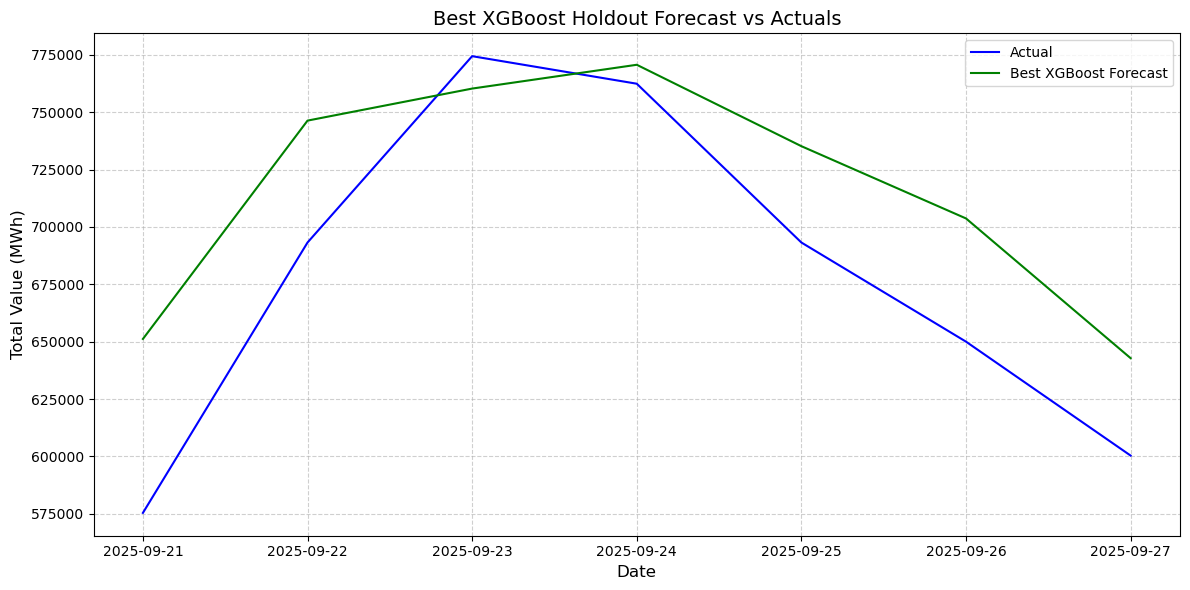

In [175]:
# Retrain best model on full training data
best_xgb = grid.best_estimator_
best_xgb.fit(X_train, Y_train)
# Forecast on holdout set
y_holdout_pred = best_xgb.predict(X_va.tail(7))
holdout_rmse_best_xgb = sqrt(mean_squared_error(holdout_actual, y_holdout_pred))
print(f"Best XGBoost Holdout RMSE: {holdout_rmse_best_xgb:.2f}")
# Plot best XGBoost holdout forecast vs actuals
plt.figure(figsize=(12,6))
plt.plot(holdout_actual.index, holdout_actual, label='Actual', color='blue')
plt.plot(holdout_actual.index, y_holdout_pred, label='Best XGBoost Forecast', color='green')
plt.title('Best XGBoost Holdout Forecast vs Actuals', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Value (MWh)', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [160]:
X_va.head()

temperature_avg_c  precipitation_mm  wind_speed_kmh  \
date                                                              
2024-05-23          -0.151296         -0.196275        0.527795   
2024-05-24          -0.214113         -0.196275        0.082261   
2024-05-25          -0.214113         -0.226102        1.702385   
2024-05-26          -0.130356         -0.226102        0.406286   
2024-05-27          -0.130356         -0.226102        0.284776   

            humidity_percent  pressure_hpa  trend  day_of_week_1  \
date                                                               
2024-05-23          0.373080     -0.459851   1969              0   
2024-05-24          0.549129     -0.539936   1970              0   
2024-05-25          0.197031     -0.032728   1971              0   
2024-05-26          0.431763      0.207528   1972              0   
2024-05-27          0.607812      0.341004   1973              0   

            day_of_week_2  day_of_week_3  day_of_week_4  ...  month_6  \
date                                                     ...            
2024-05-23              0              1              0  ...        0   
2024-05-24              0              0              1  ...        0   
2024-05-25              0              0              0  ...        0   
2024-05-26              0              0              0  ...        0   
2024-05-27              0              0              0  ...        0   

            month_7  month_8  month_9  month_10  month_11  month_12  \
date                                                                  
2024-05-23        0        0        0         0         0         0   
2024-05-24        0        0        0         0         0         0   
2024-05-25        0        0        0         0         0         0   
2024-05-26        0        0        0         0         0         0   
2024-05-27        0        0        0         0         0         0   

            is_weekend_1     lag_7   lag_365  
date                                          
2024-05-23             0  0.519557  0.223247  
2024-05-24             0  0.295549  0.254632  
2024-05-25             1 -0.057444  0.134885  
2024-05-26             1 -0.287567 -0.244156  
2024-05-27             0  0.085212 -0.244576  

[5 rows x 26 columns]

In [161]:
y_va.tail()

date
2025-09-23    774430.0
2025-09-24    762427.0
2025-09-25    693233.0
2025-09-26    650032.0
2025-09-27    600388.0
Name: total_value, dtype: float64

In [176]:
# Test on 2024-0701 to 2024-07-07
test_start_date = '2024-07-01'
test_end_date = '2024-07-07'
X_test_2 = X_va.loc[test_start_date:test_end_date]
y_test_2 = y_va.loc[test_start_date:test_end_date]
# Forecast with best XGBoost model
y_test_pred = best_xgb.predict(X_test)
test_rmse_best_xgb = sqrt(mean_squared_error(y_test, y_test_pred))
print(f"Best XGBoost Test RMSE ({test_start_date} to {test_end_date}): {test_rmse_best_xgb:.2f}")



Best XGBoost Test RMSE (2024-07-01 to 2024-07-07): 3644.37
